<a href="https://colab.research.google.com/github/aregeezra/Housing/blob/main/HousingProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.0 IMPORTS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display  import HTML
from IPython.display       import Image
from datetime              import date
from tabulate              import tabulate
from scipy.stats           import chi2_contingency
import missingno as msno
from scipy.stats           import chi2_contingency

#0.1 Helper Function

In [ ]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 48
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [ ]:
settings()

Populating the interactive namespace from numpy and matplotlib


#1. Defining the Question : 
## a) Specifying the Question

> Study the factors that affect housing prices.




## b) Defining the Metric for Success
> Accurately predict the the sale of prices upon being provided with the predictor variables



#2. Loading Data

In [ ]:
#load our data
df = pd.read_csv('./house.csv')

In [ ]:
#check the first five rows
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# 3. DESCRIPTION OF DATA

In [ ]:
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

## a) Data Dimensions


In [ ]:
print( 'Number of Rows: {}'.format( df.shape[0] ) )
print( 'Number of Cols: {}'.format( df.shape[1] ) )

Number of Rows: 21613
Number of Cols: 20


## b) Data Types

In [ ]:
pd.DataFrame({'Data Types': df.dtypes})

,Data Types
id,int64
price,float64
bedrooms,int64
bathrooms,float64
sqft_living,int64
sqft_lot,int64
floors,float64
waterfront,int64
view,int64
condition,int64


## Change Data Types

In [ ]:
# change relevant data types since the are categorical in nature
df['id'] = df['id'].astype(str)
df['waterfront'] = df['waterfront'].astype(str)
df['view'] = df['view'].astype(str)
df['condition'] = df['condition'].astype(str)
df['zipcode'] = df['zipcode'].astype(str)

## c) Check NA

In [ ]:
# We have no missing values in our data set 
df.isna().sum()

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

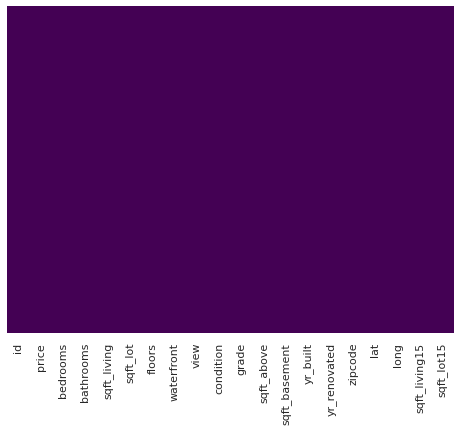

In [ ]:
# We have no missing values in our data set
plt.figure(figsize=(8,6))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#4.0 Descriptive Statistical

In [ ]:
# Divide data into numerical and categorical attribiutes as they will be treated with different techniques

num_attributes = df.select_dtypes(include =['int64', 'float64'])
cat_attributes = df.select_dtypes(exclude=['float64', 'int64'])


In [ ]:
num_attributes.sample()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
2713,1110000.0,5,3.5,7350,12231,2.0,11,4750,2600,2001,0,47.5373,-121.865,5380,12587


In [ ]:
cat_attributes.sample()

,id,waterfront,view,condition,zipcode
3071,5652601425,0,0,3,98115


## a) Numerical Attributes

In [ ]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
d7 = pd.DataFrame( num_attributes.apply(lambda x: x.var())).T
# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6, d7] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'Variance'])

In [ ]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis,Variance
0,price,75000.0000,7.700000e+06,7.625000e+06,540182.158793,450000.0000,367353.732979,4.021716,34.522444,1.349550e+11
1,bedrooms,0.0000,3.300000e+01,3.300000e+01,3.370842,3.0000,0.930040,1.974300,49.063653,8.650150e-01
2,bathrooms,0.0000,8.000000e+00,8.000000e+00,2.114757,2.2500,0.770145,0.511108,1.279902,5.931513e-01
3,sqft_living,290.0000,1.354000e+04,1.325000e+04,2079.899736,1910.0000,918.419649,1.471555,5.243093,8.435337e+05
4,sqft_lot,520.0000,1.651359e+06,1.650839e+06,15106.967566,7618.0000,41419.553273,13.060019,285.077820,1.715659e+09
5,floors,1.0000,3.500000e+00,2.500000e+00,1.494309,1.5000,0.539976,0.616177,-0.484723,2.915880e-01
6,grade,1.0000,1.300000e+01,1.200000e+01,7.656873,7.0000,1.175432,0.771103,1.190932,1.381703e+00
7,sqft_above,290.0000,9.410000e+03,9.120000e+03,1788.390691,1560.0000,828.071820,1.446664,3.402304,6.857347e+05
8,sqft_basement,0.0000,4.820000e+03,4.820000e+03,291.509045,0.0000,442.564804,1.577965,2.715574,1.958727e+05
9,yr_built,1900.0000,2.015000e+03,1.150000e+02,1971.005136,1975.0000,29.372731,-0.469805,-0.657408,8.627973e+02


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00e4bc7090>,
      dtype=object)

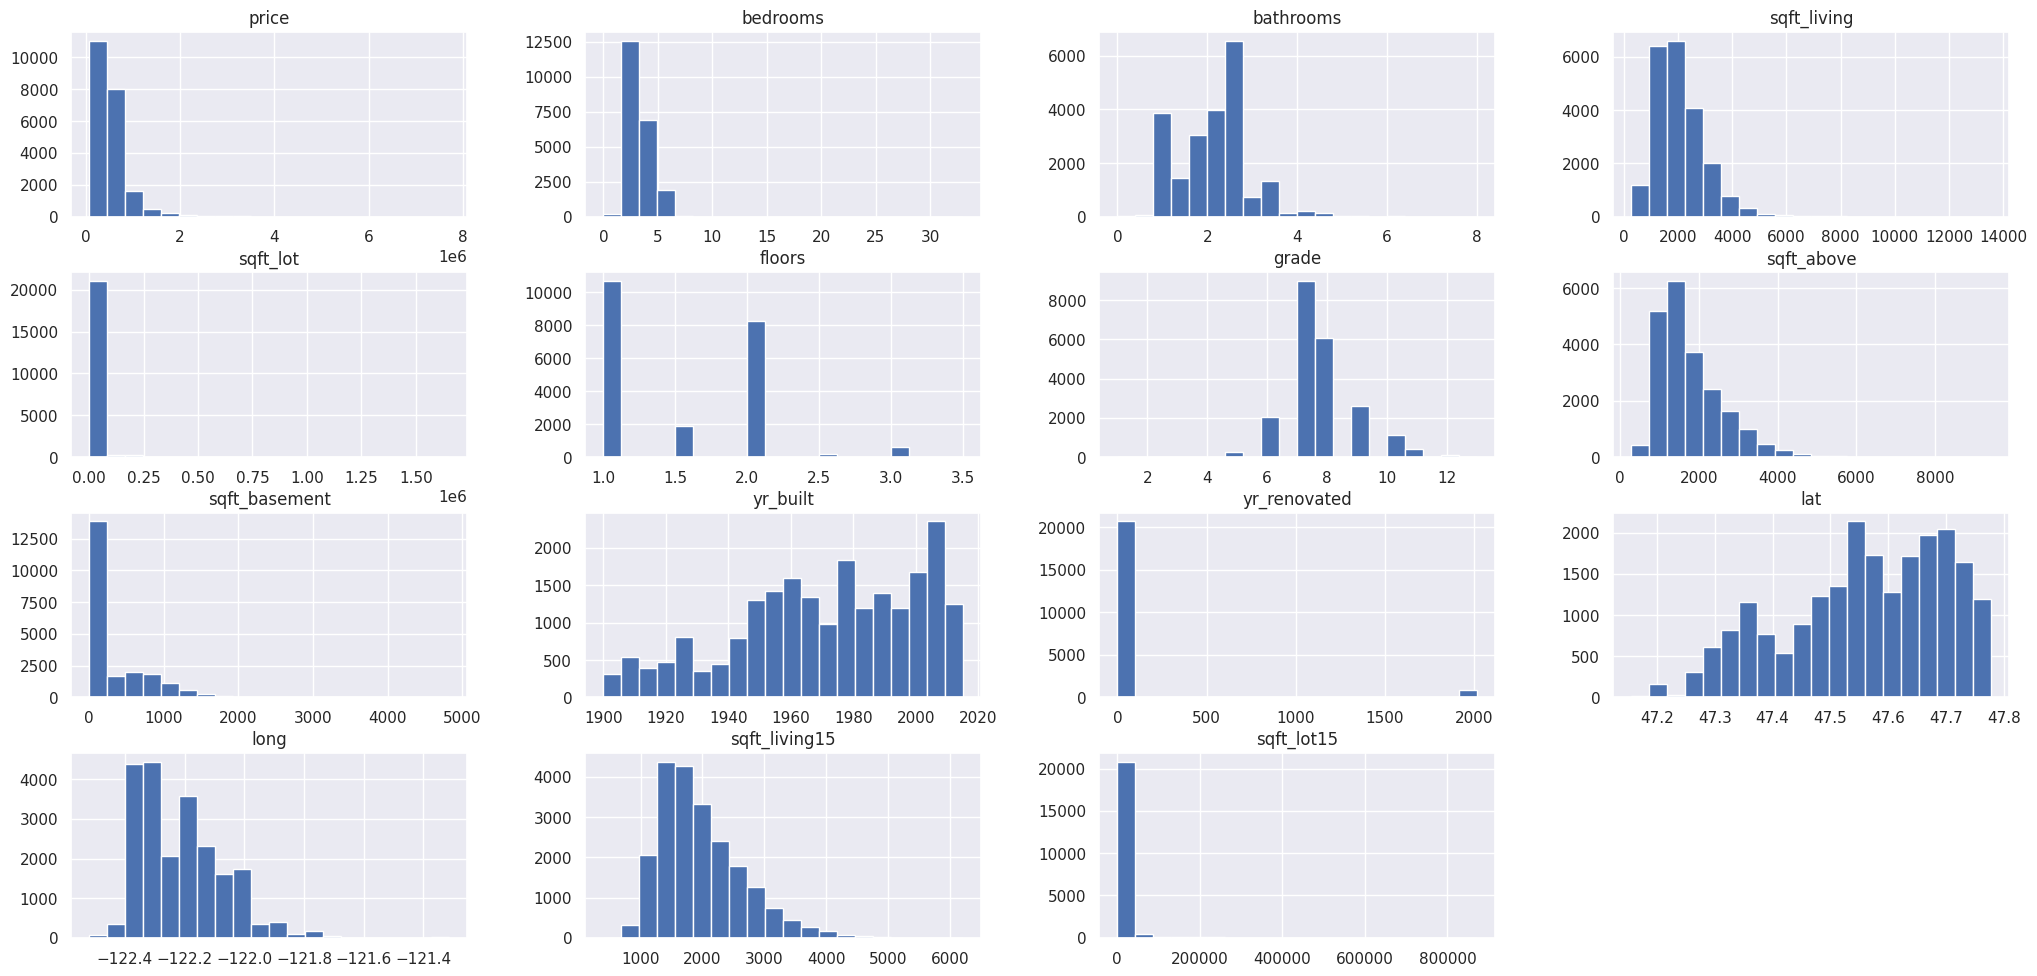

In [ ]:
num_attributes.hist(bins=20)

Text(0.5, 1.0, 'Distribution of House Prices')

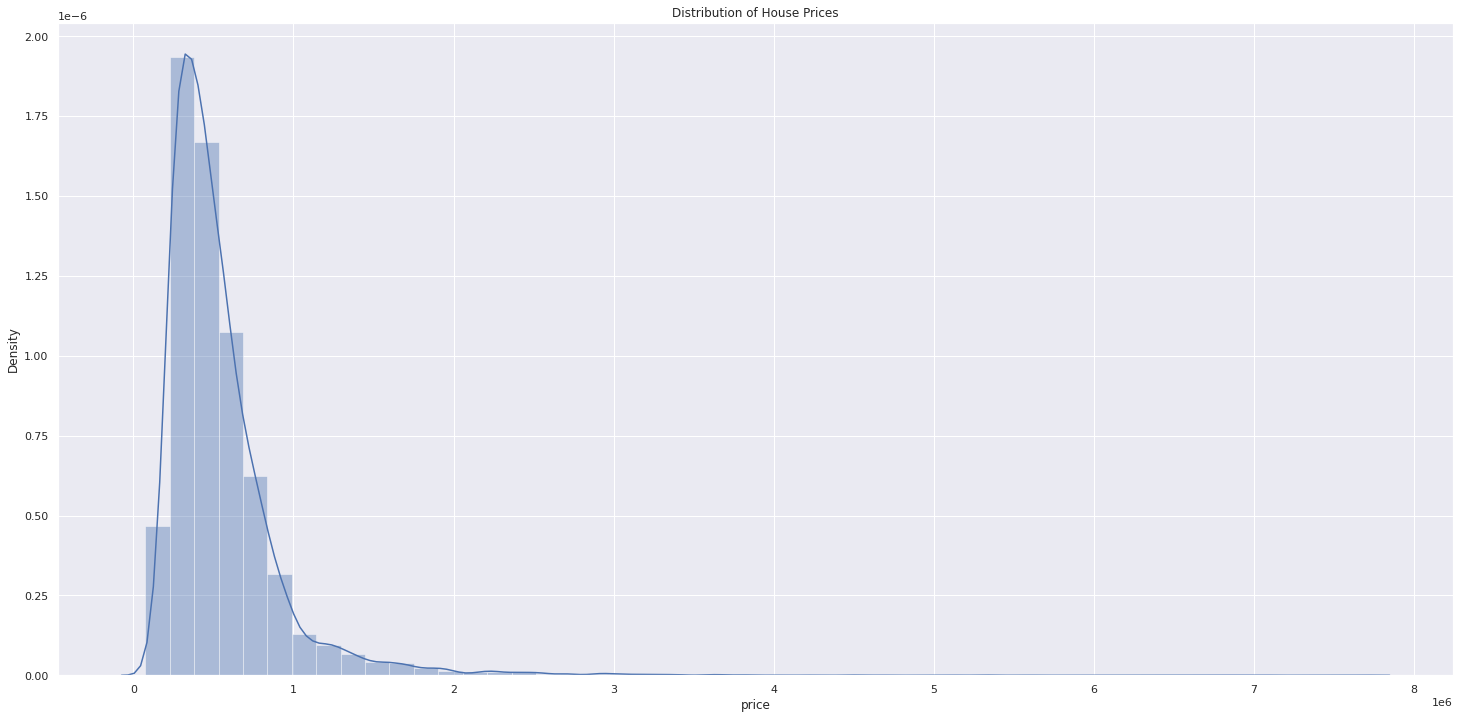

In [ ]:
sns.distplot(df['price'])
plt.title("Distribution of House Prices")

Our response variable is positively skewed since we have have a skew value of 4.021716.
We have a leptokurtic distribution since we have a high degree of peakdeness of 34

## b) Categorical Attributes

In [ ]:
cat_attributes.sample()

,id,waterfront,view,condition,zipcode
13084,518500210,0,0,3,98056


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69]), <a list of 70 Text major ticklabel objects>)

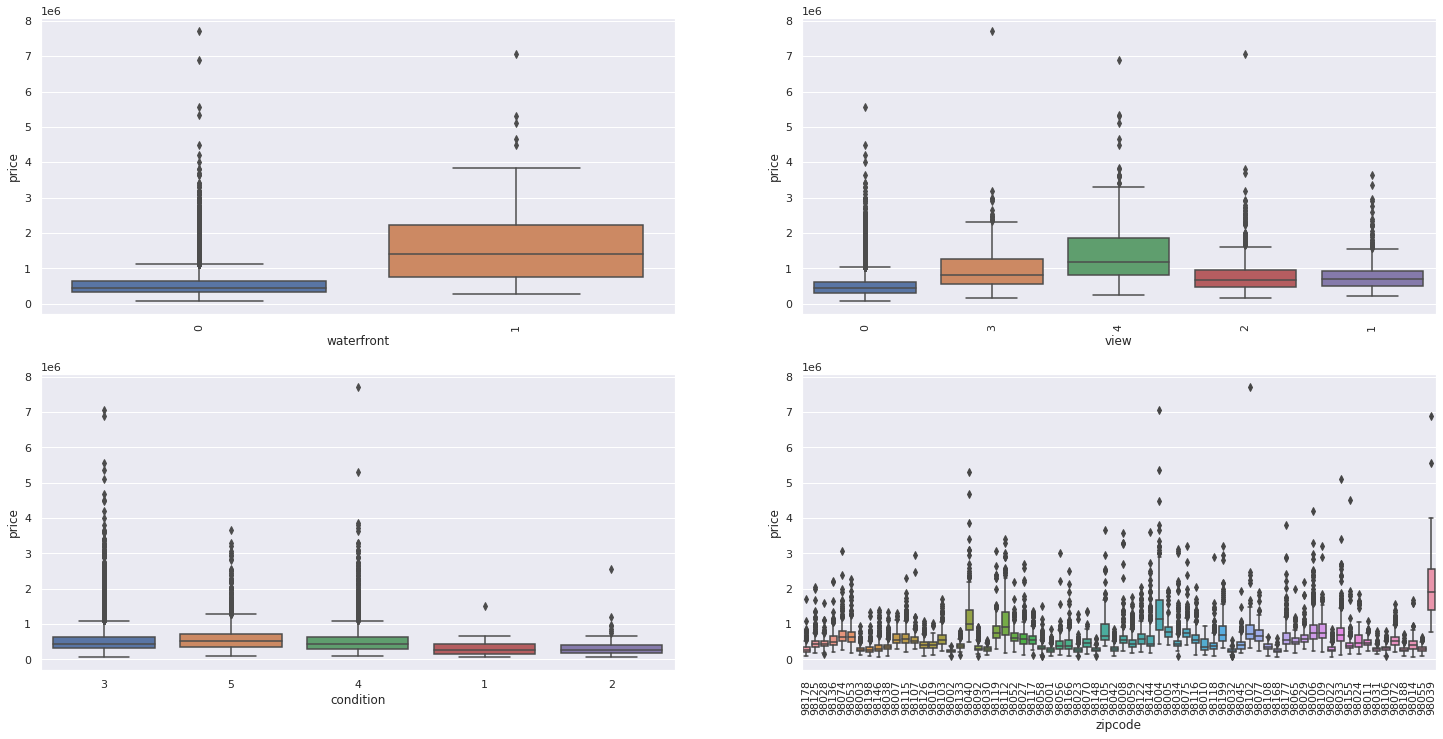

In [ ]:

plt.subplot(2, 2, 1 )
sns.boxplot( x= 'waterfront', y='price' , data=df )
plt.xticks(rotation=90)

plt.subplot(2, 2, 2 )
sns.boxplot( x= 'view', y='price' , data=df )
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
sns.boxplot( x= 'condition', y='price' , data=df )


plt.subplot(2, 2, 4
            )
sns.boxplot( x= 'zipcode', y='price' , data=df )
plt.xticks(rotation=90)


We definately have a lot of outliers we will have to deal with them later before modelling

#5.0 EXPLORATORY DATA ANALYSIS

##5.1 Univariate Analysis

###5.1.1 Response Varriable

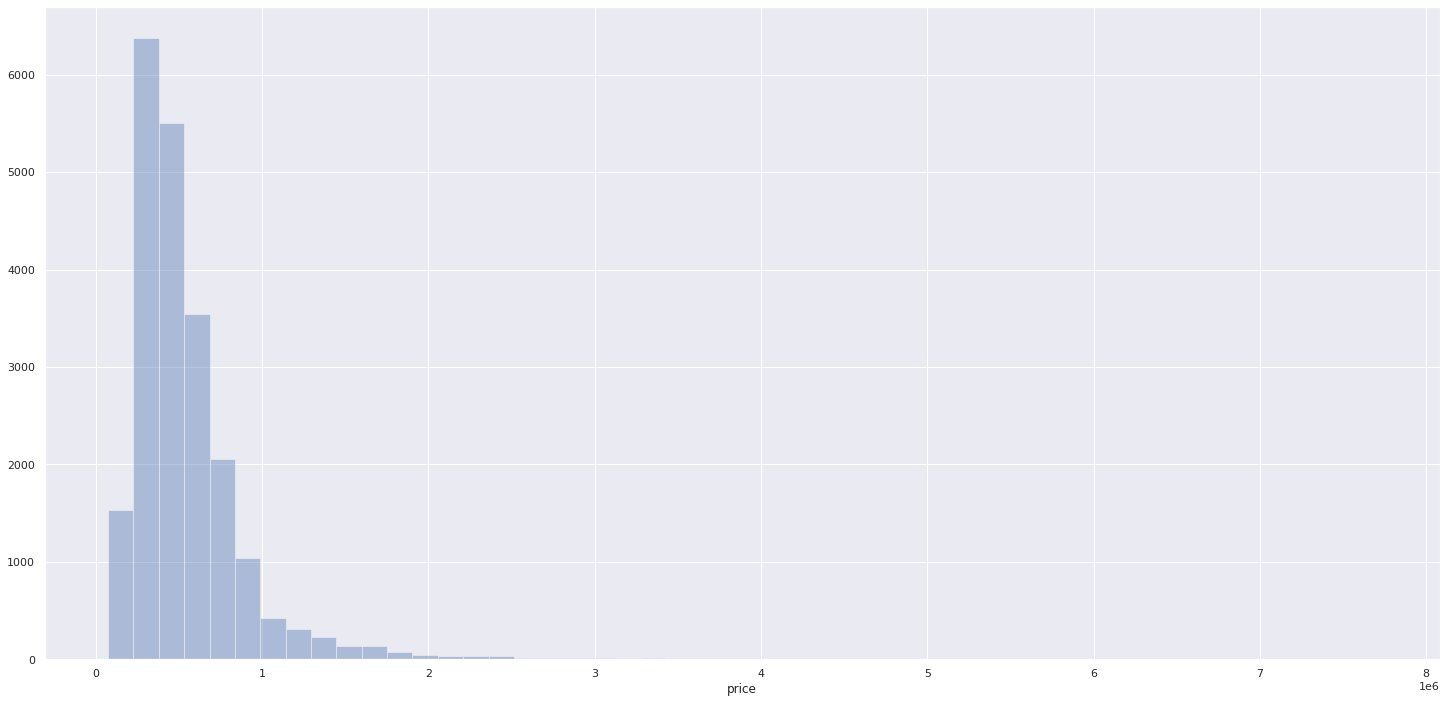

In [ ]:
sns.distplot( df['price'], kde=False )

Our response variable is positively skewed since we have have a skew value of 4.021716.
We have a leptokurtic distribution since we have a high degree of peakdeness of 34

### 5.1.2 Numerical Variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00fdaf5490>,
      dtype=object)

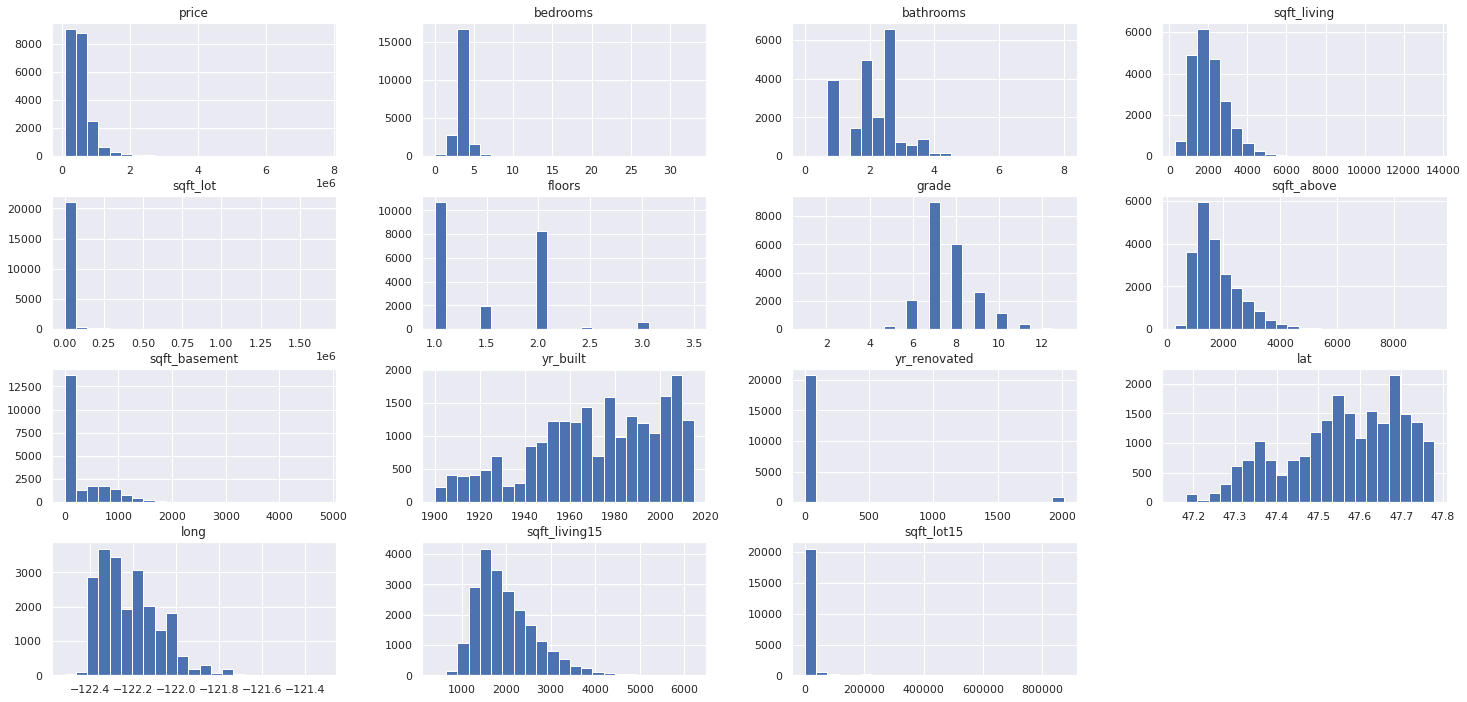

In [ ]:
num_attributes.hist(bins=23)

### 5.1.3 Categorical variables


In [ ]:
cat_attributes.sample()

,id,waterfront,view,condition,zipcode
13463,7701990040,0,0,3,98077


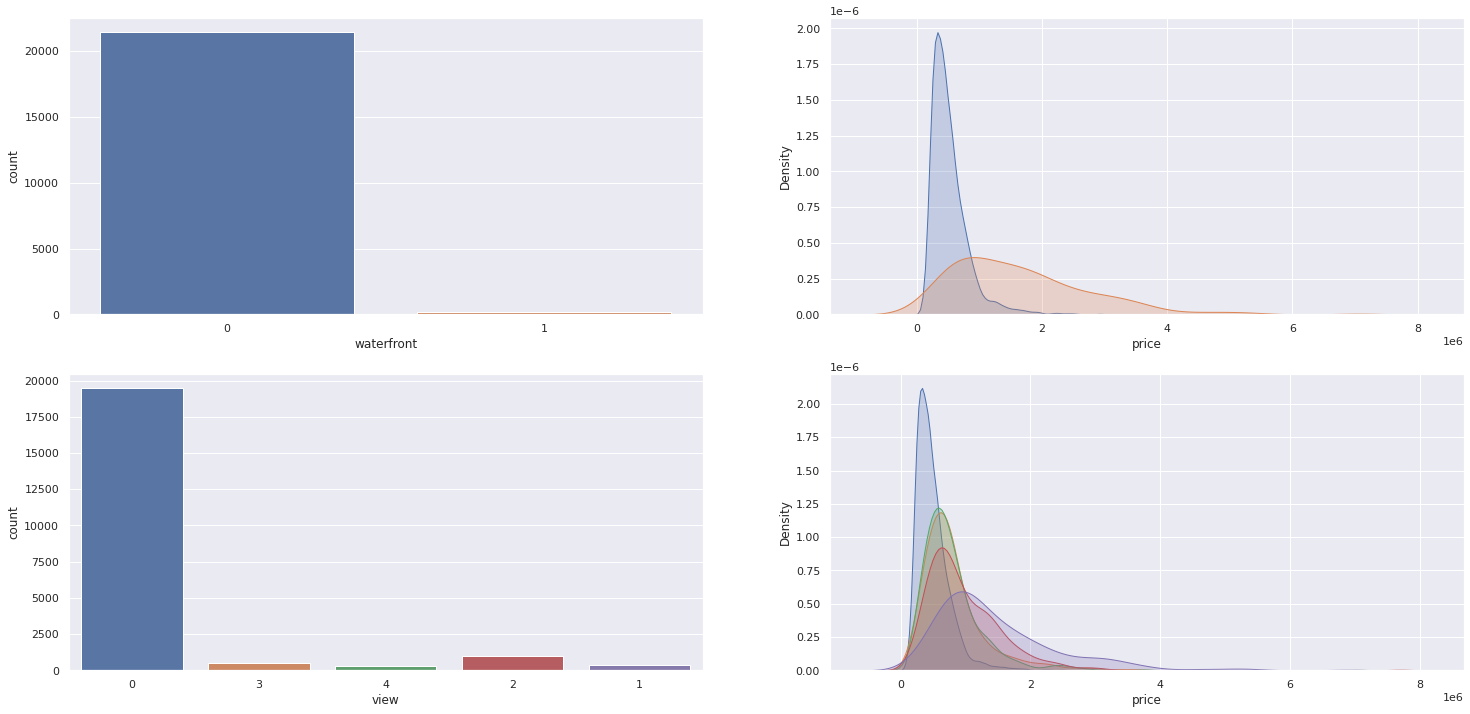

In [ ]:
plt.subplot(2, 2, 1)
sns.countplot(df['waterfront'])

plt.subplot(2, 2, 2)
sns.kdeplot( df[df['waterfront'] =='0']['price'], label='No WaterFront', shade=True)
sns.kdeplot( df[df['waterfront'] =='1']['price'], label='WaterFront', shade=True)

plt.subplot(2, 2, 3)
sns.countplot(df['view'])

plt.subplot(2, 2, 4)
sns.kdeplot( df[df['view'] =='0']['price'], label='View One', shade=True)
sns.kdeplot( df[df['view'] =='1']['price'], label='View Two', shade=True)
sns.kdeplot( df[df['view'] =='2']['price'], label='View Three', shade=True)
sns.kdeplot( df[df['view'] =='3']['price'], label='View Four', shade=True)
sns.kdeplot( df[df['view'] =='4']['price'], label='View Five', shade=True)


## 5.2 Bivariate Analysis

####The price of a house increases with the increase of square footage no of rooms

In [ ]:
df.sample()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8133,7849202585,170000.0,1,1.0,480,4560,1.0,0,0,3,5,480,0,1922,0,98065,47.5253,-121.826,890,4803


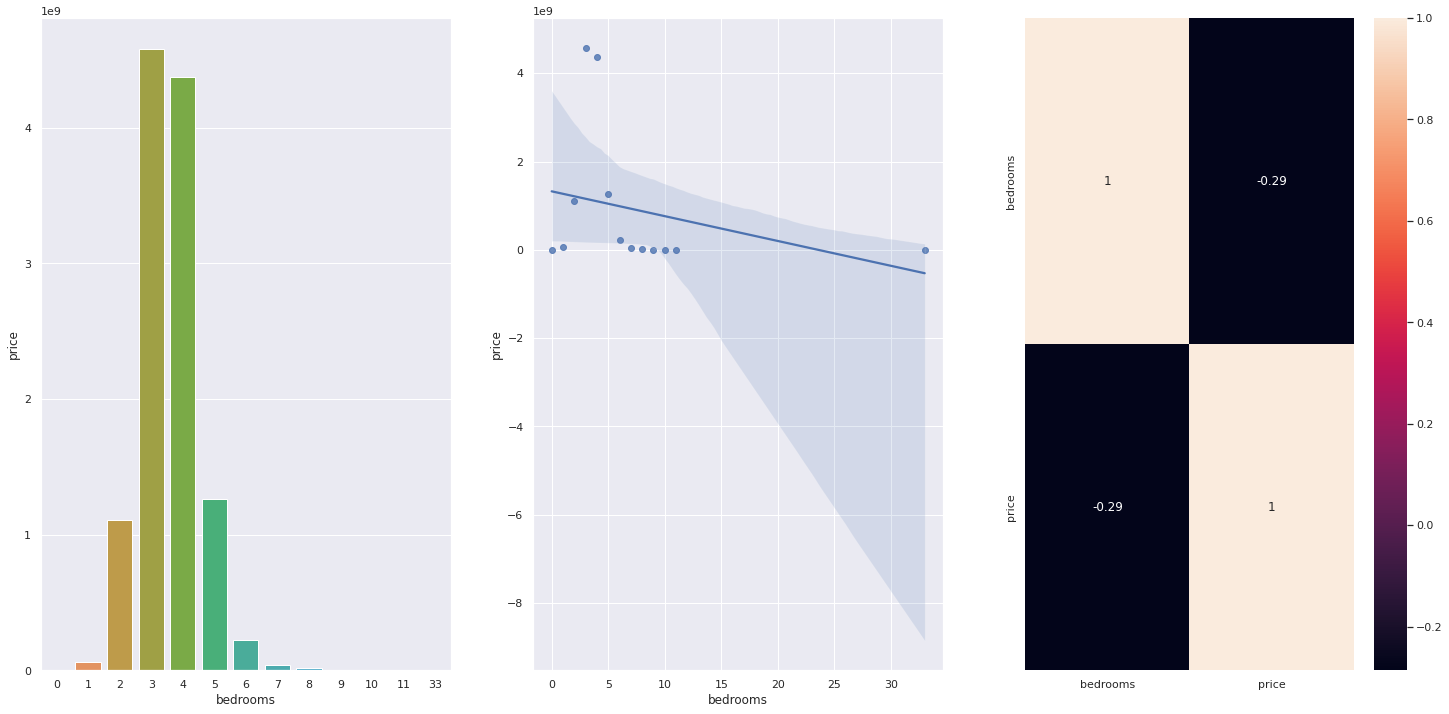

In [ ]:
plt.subplot(1, 3, 1)
aux1 = df[['bedrooms', 'price']].groupby('bedrooms').sum().reset_index()
sns.barplot(x='bedrooms', y='price', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='bedrooms', y='price', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

We clearly do not have a linear relationship between no of bedrooms and price of houses, In addition they are negatively correlated thus no relationship whatsoever

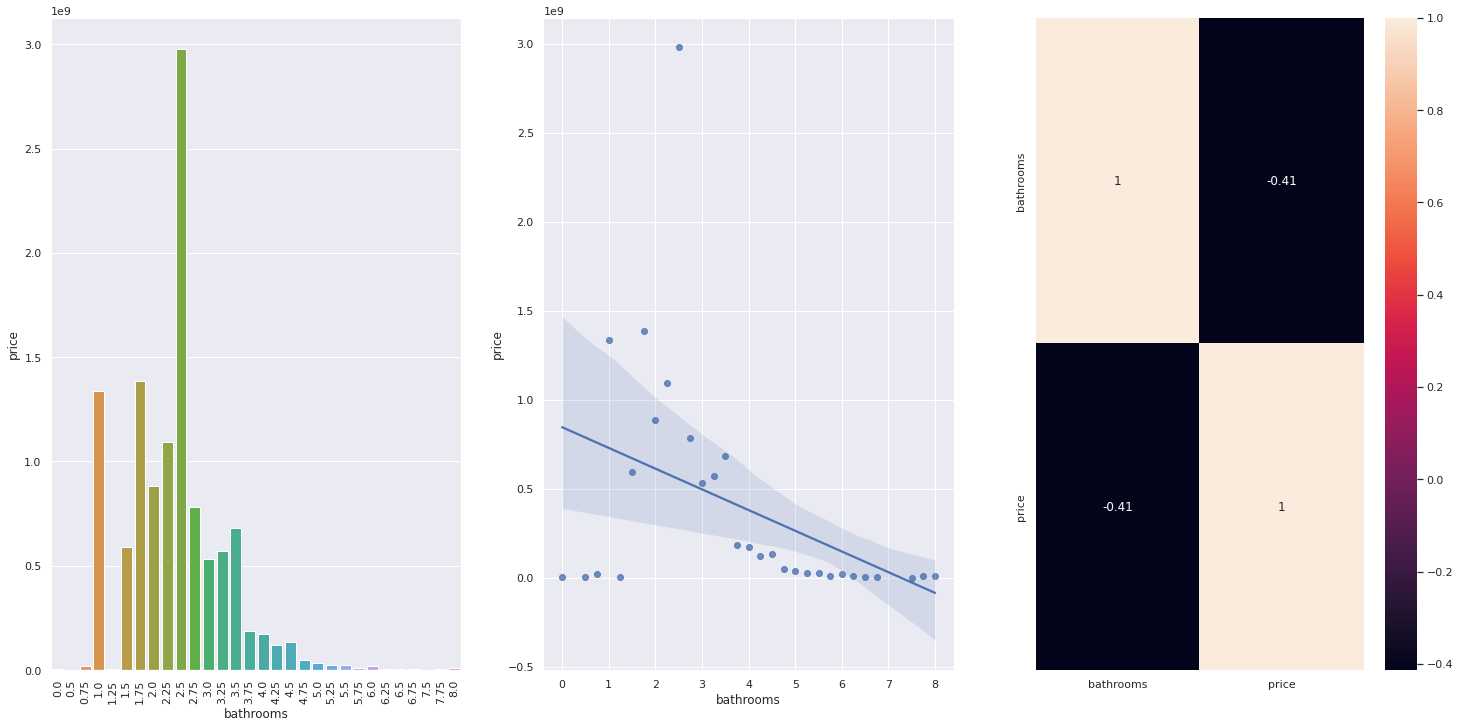

In [ ]:
|plt.subplot(1, 3, 1)
aux2 = df[['bathrooms', 'price']].groupby('bathrooms').sum().reset_index()
sns.barplot(x='bathrooms', y='price', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='bathrooms', y='price', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux2.corr(method='pearson'), annot=True)

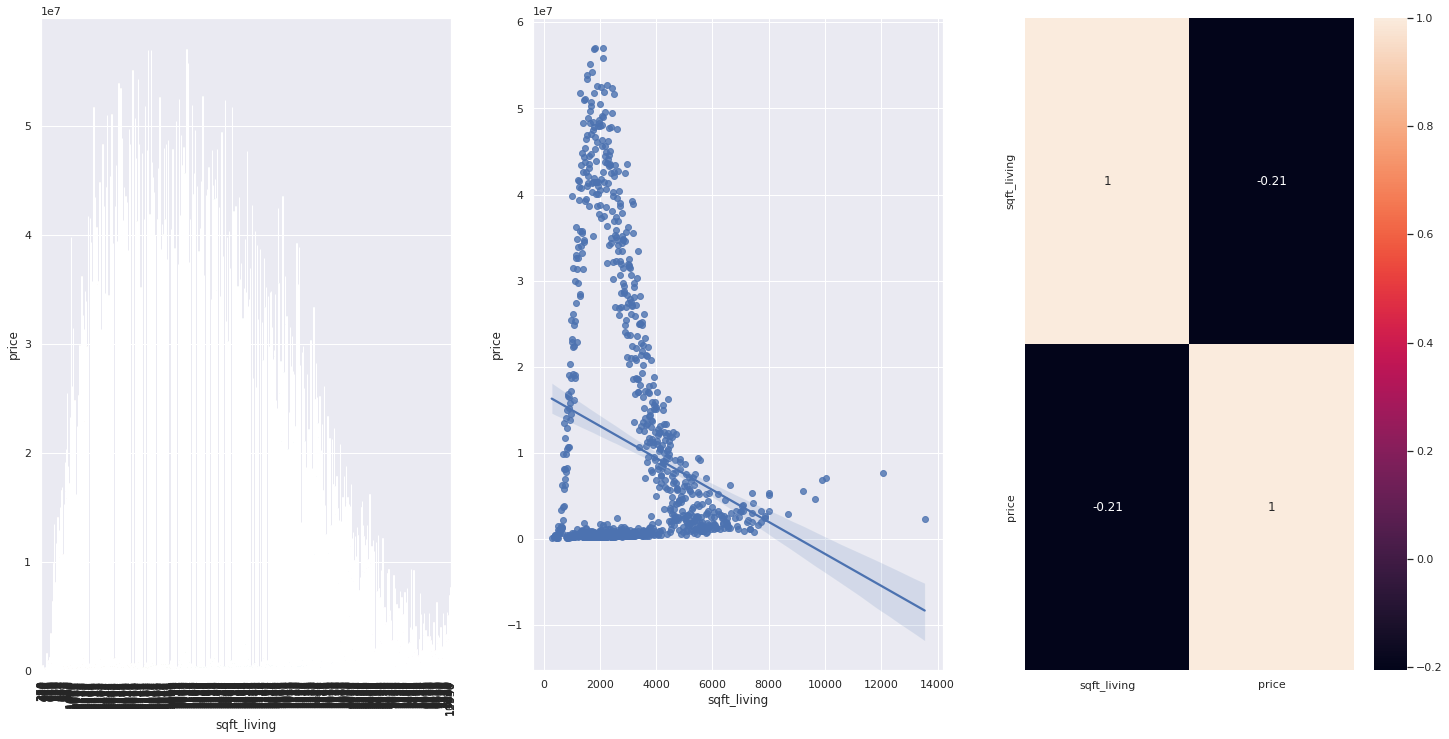

In [ ]:
plt.subplot(1, 3, 1)
aux3 = df[['sqft_living', 'price']].groupby('sqft_living').sum().reset_index()
sns.barplot(x='sqft_living', y='price', data=aux3)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='sqft_living', y='price', data=aux3)

plt.subplot(1, 3, 3)
sns.heatmap(aux3.corr(method='pearson'), annot=True)

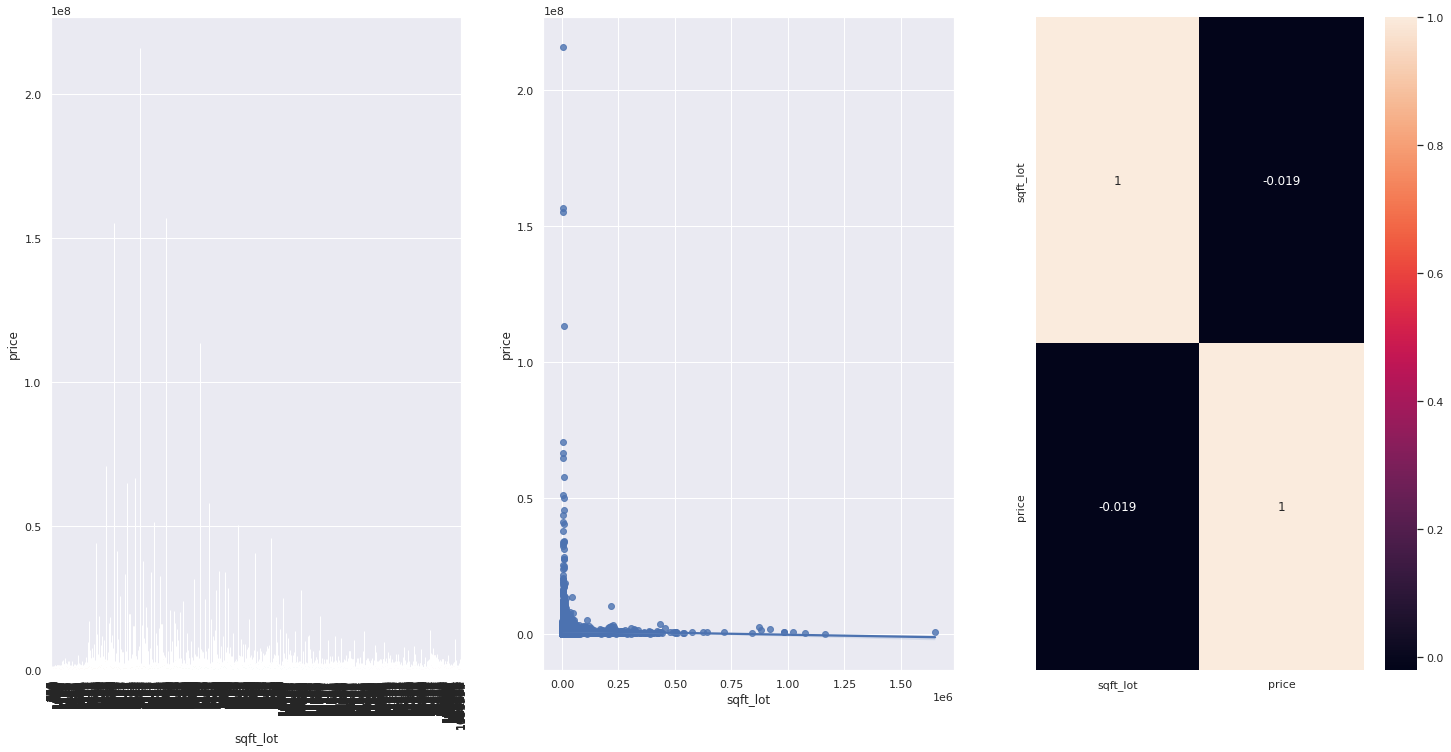

In [ ]:
plt.subplot(1, 3, 1)
aux4 = df[['sqft_lot', 'price']].groupby('sqft_lot').sum().reset_index()
sns.barplot(x='sqft_lot', y='price', data=aux4)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='sqft_lot', y='price', data=aux4)

plt.subplot(1, 3, 3)
sns.heatmap(aux4.corr(method='pearson'), annot=True)

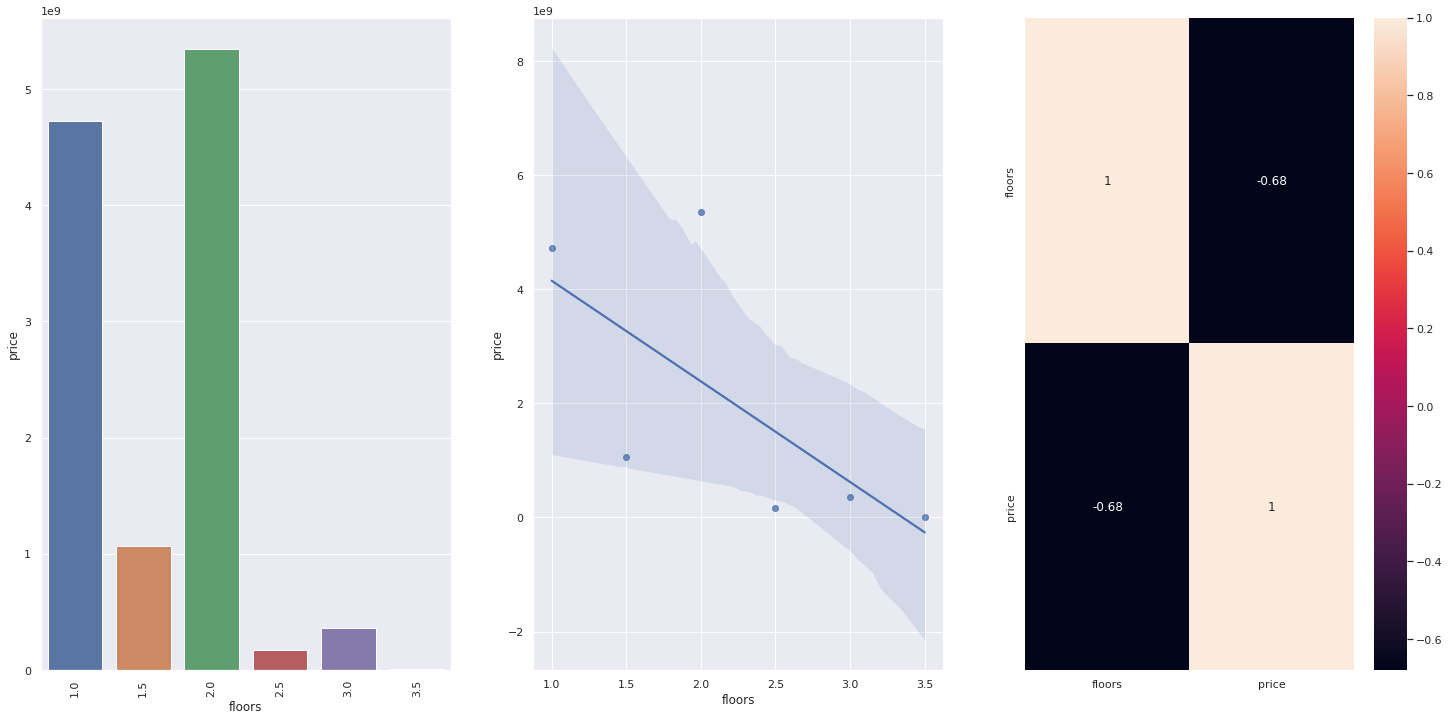

In [ ]:
plt.subplot(1, 3, 1)
aux5 = df[['floors', 'price']].groupby('floors').sum().reset_index()
sns.barplot(x='floors', y='price', data=aux5)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='floors', y='price', data=aux5)

plt.subplot(1, 3, 3)
sns.heatmap(aux5.corr(method='pearson'), annot=True)

In [ ]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


##5.3 Multivariate Analysis

###5.3.1 Numerical Attributes

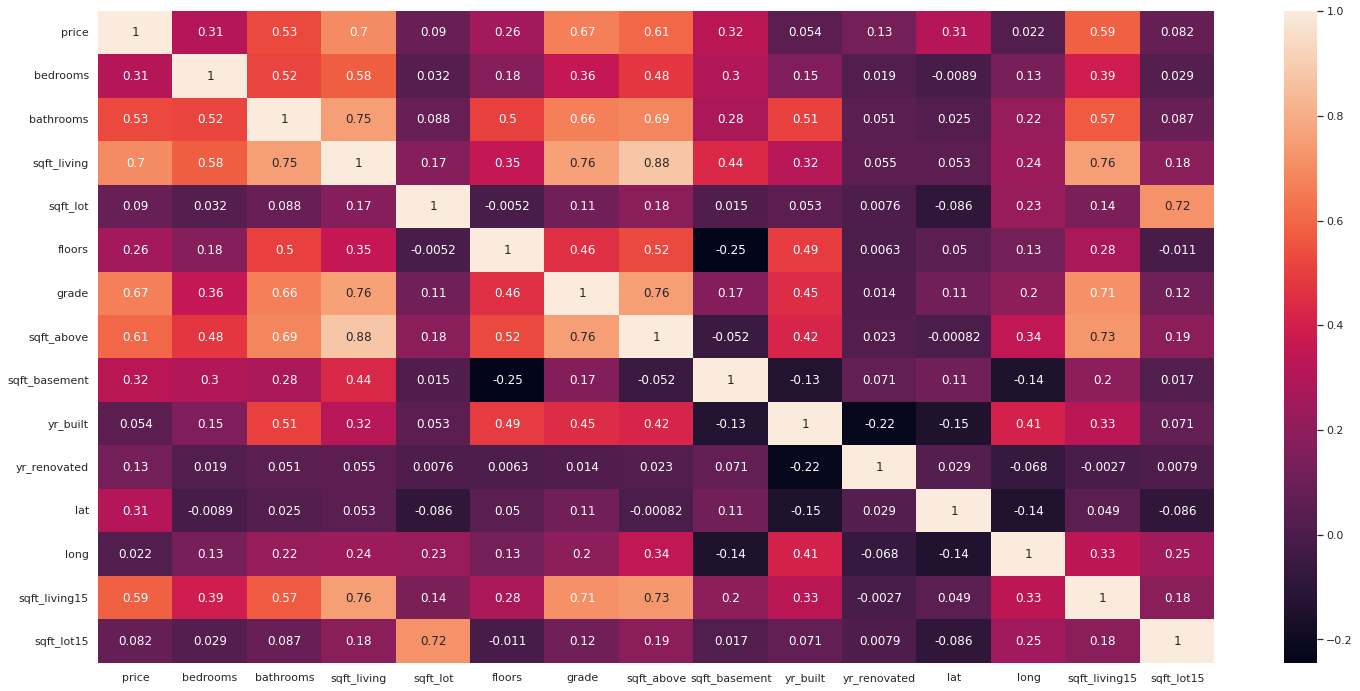

In [ ]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )


#5.3.2 Categorical Attributes

In [ ]:
cat_attributes.sample()

,id,waterfront,view,condition,zipcode
20114,3818400110,0,0,3,98028


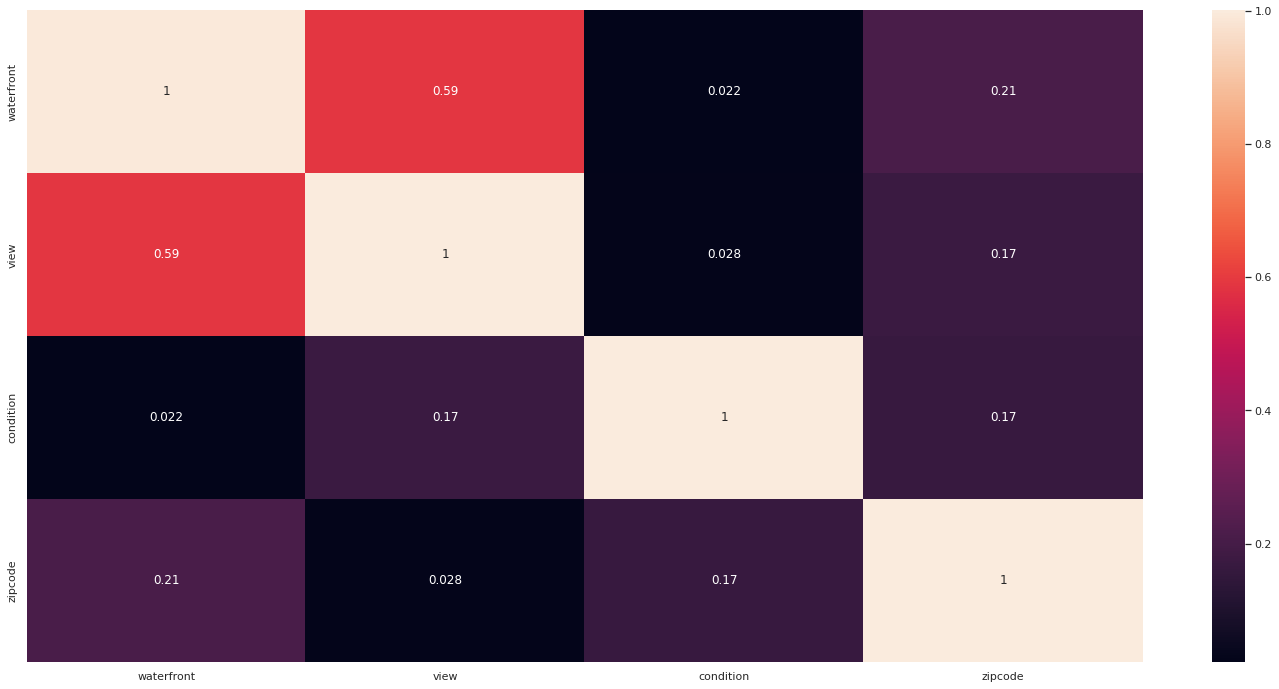

In [ ]:
c1 = cramer_v( df['waterfront'], df['waterfront'])
c2 = cramer_v( df['waterfront'],df['view'])
c3 = cramer_v( df['waterfront'],df['condition'])
c4 = cramer_v( df['waterfront'],df['zipcode'])

c5 = cramer_v( df['view'],df['waterfront'])
c6 = cramer_v( df['view'],df['view'])
c7 = cramer_v( df['view'],df['zipcode'])
c8 = cramer_v( df['view'], df['condition'])

c9 = cramer_v( df['condition'],df['waterfront'])
c10 = cramer_v( df['condition'],df['view'])
c11 = cramer_v( df['condition'],df['condition'])
c12 = cramer_v( df['condition'], df['zipcode'])

c13 = cramer_v(df['zipcode'], df['waterfront'])
c14 = cramer_v(df['zipcode'], df['view'])
c15 = cramer_v(df['zipcode'], df['condition'])
c16 = cramer_v(df['zipcode'], df['zipcode'])

d = pd.DataFrame( {'waterfront': [c1, c2, c3, c4],
                    'view': [c5, c6, c7, c8],
                    'condition': [c9, c10, c11, c12],
                    'zipcode':[c13, c14, c15, c16]} )

d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

In [ ]:
df1 = df.copy()

# DATA PREPARATION

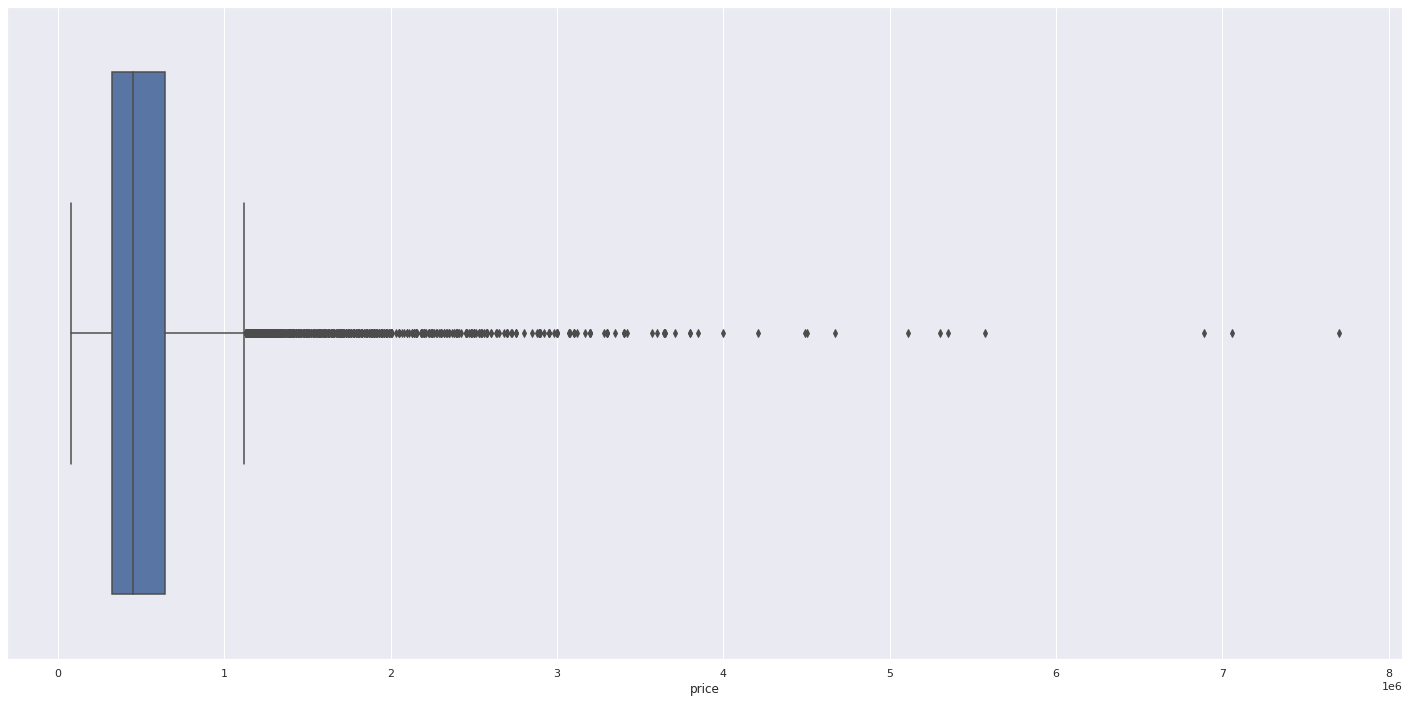

In [ ]:
sns.boxplot( df1['price'])

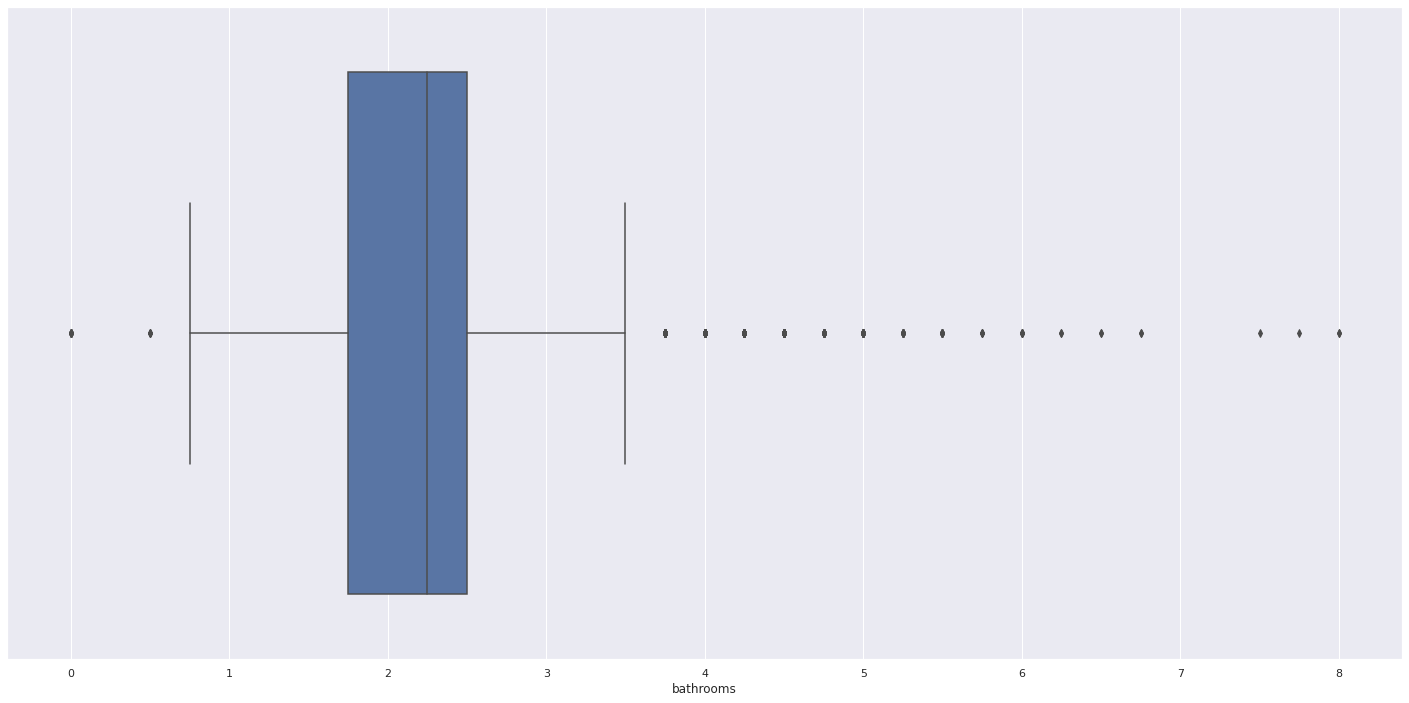

In [ ]:
sns.boxplot(df1['bathrooms'])

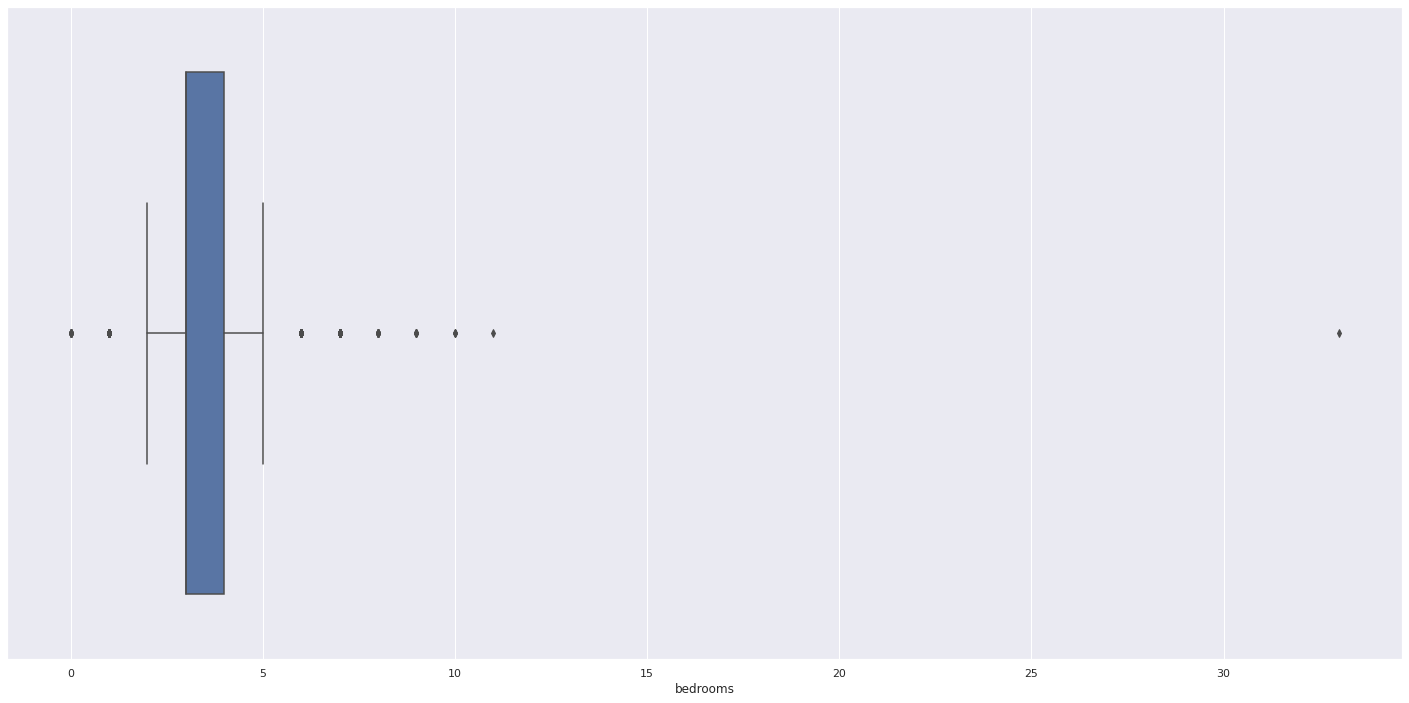

In [ ]:
sns.boxplot(df1['bedrooms'])

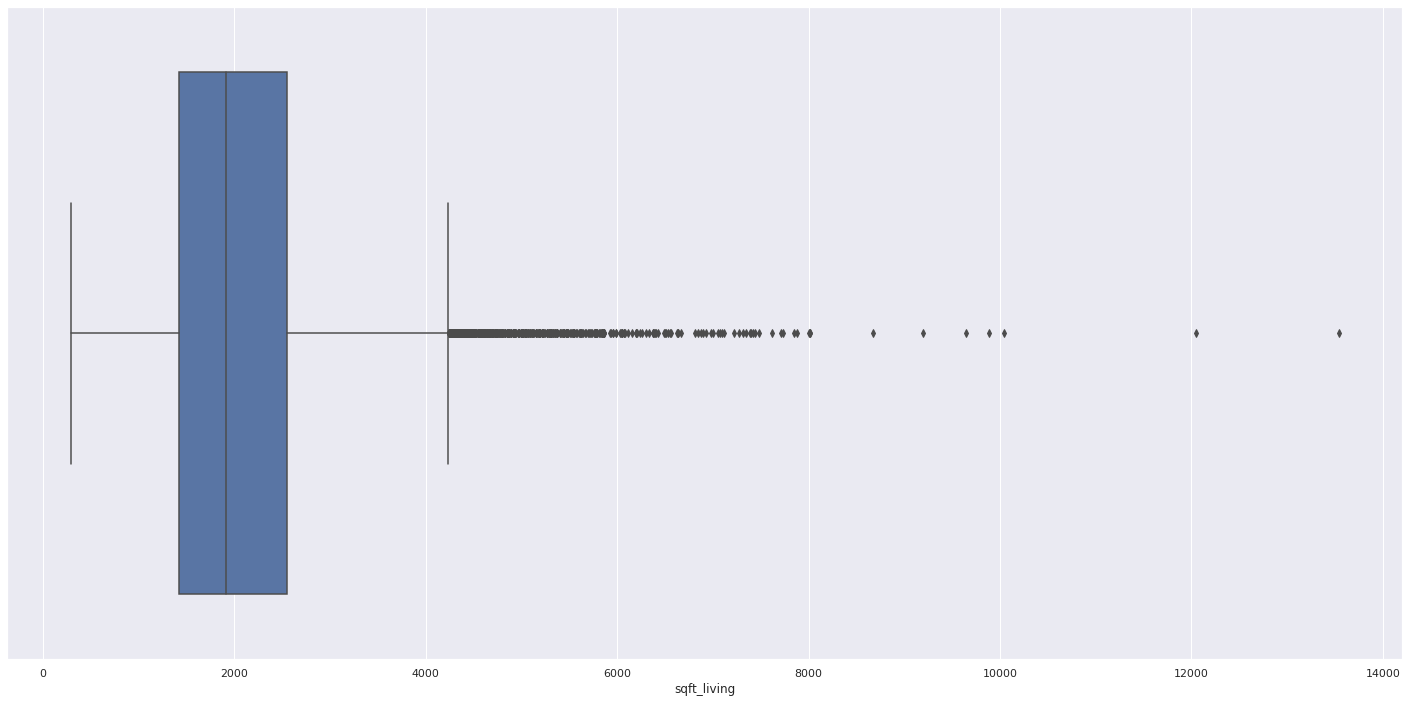

In [ ]:
sns.boxplot(df1['sqft_living'])

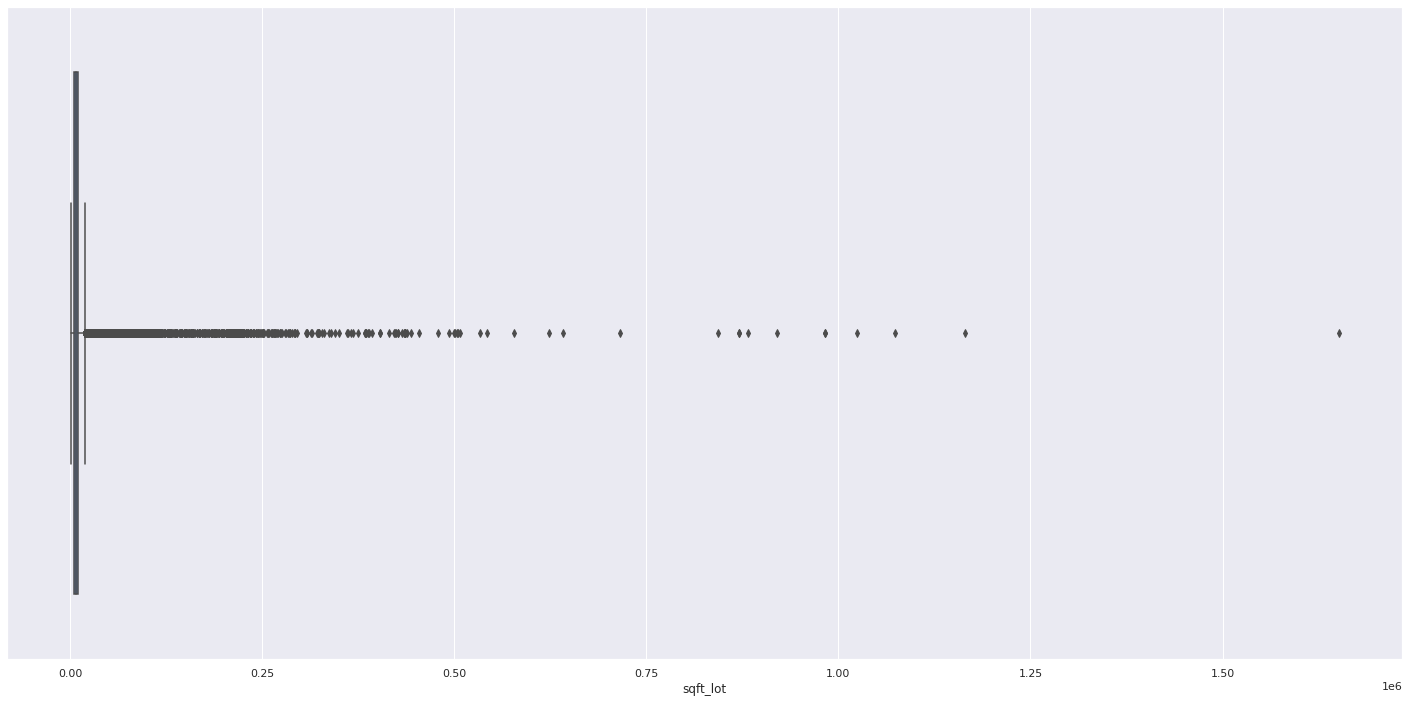

In [ ]:
sns.boxplot(df1['sqft_lot'])

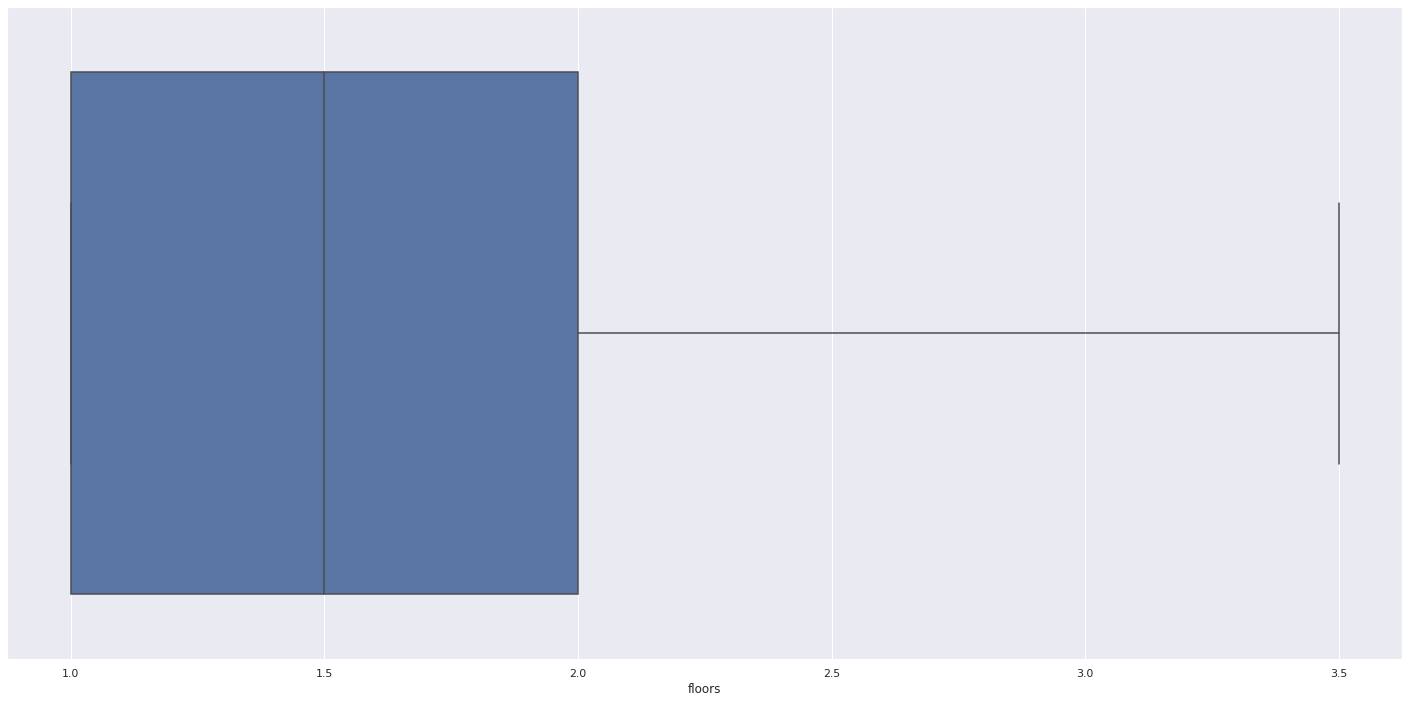

In [ ]:
sns.boxplot(df1['floors'])

In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
rs = RobustScaler()

In [ ]:
df1['price'] = rs.fit_transform( df1[['price']].values)

df1['bathrooms'] = rs.fit_transform( df1[['bathrooms']].values)

df1['bedrooms'] = rs.fit_transform( df1[['bedrooms']].values)

df1['sqft_living'] = rs.fit_transform( df1[['sqft_living']].values)

df1['sqft_lot'] = rs.fit_transform( df1[['sqft_lot']].values)

df1['floors'] = rs.fit_transform( df1[['floors']].values)

#6.0 MACHINE LEARNING

#6.1 Check for Multicollinearity

In [ ]:
df1.sample()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4177,9523100459,0.315741,-1.0,0.333333,-0.47195,-1.180418,1.5,0,0,3,9,1380,0,2006,0,98103,47.6654,-122.355,1430,3400


In [ ]:
#Separate independent and dependent variables

ind = df1.drop(columns=['id','price'])

corr =ind.corr()

In [ ]:
corr

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
bedrooms,1.000000,0.515884,0.576671,0.031703,0.175429,0.356967,0.477600,0.303093,0.154178,0.018841,-0.008931,0.129473,0.391638,0.029244
bathrooms,0.515884,1.000000,0.754665,0.087740,0.500653,0.664983,0.685342,0.283770,0.506019,0.050739,0.024573,0.223042,0.568634,0.087175
sqft_living,0.576671,0.754665,1.000000,0.172826,0.353949,0.762704,0.876597,0.435043,0.318049,0.055363,0.052529,0.240223,0.756420,0.183286
sqft_lot,0.031703,0.087740,0.172826,1.000000,-0.005201,0.113621,0.183512,0.015286,0.053080,0.007644,-0.085683,0.229521,0.144608,0.718557
floors,0.175429,0.500653,0.353949,-0.005201,1.000000,0.458183,0.523885,-0.245705,0.489319,0.006338,0.049614,0.125419,0.279885,-0.011269
grade,0.356967,0.664983,0.762704,0.113621,0.458183,1.000000,0.755923,0.168392,0.446963,0.014414,0.114084,0.198372,0.713202,0.119248
sqft_above,0.477600,0.685342,0.876597,0.183512,0.523885,0.755923,1.000000,-0.051943,0.423898,0.023285,-0.000816,0.343803,0.731870,0.194050
sqft_basement,0.303093,0.283770,0.435043,0.015286,-0.245705,0.168392,-0.051943,1.000000,-0.133124,0.071323,0.110538,-0.144765,0.200355,0.017276
yr_built,0.154178,0.506019,0.318049,0.053080,0.489319,0.446963,0.423898,-0.133124,1.000000,-0.224874,-0.148122,0.409356,0.326229,0.070958
yr_renovated,0.018841,0.050739,0.055363,0.007644,0.006338,0.014414,0.023285,0.071323,-0.224874,1.000000,0.029398,-0.068372,-0.002673,0.007854


The table above shows us how each variable relates to another. The coefficient of 1 across the diagonal makes sense, as a variable is perfectly correlated to itself. Let's use these correlations to compute the Variance Inflation Factor (VIF)-Measures the severity of multicollinearity in regression analysis score for each variable. This will require a little bit of linear algebra, but the approach is straightforward: we create a new dataframe with the inverse of the matrix above.

In [ ]:
pd.DataFrame(np.linalg.inv(corr.values), 
             index = corr.index, columns=corr.columns)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
bedrooms,1.624960,-0.465983,9.158119e-02,0.055214,0.069609,0.316605,-9.639528e-01,-5.006958e-01,0.128339,0.063899,0.057494,-0.039185,0.049105,0.087797
bathrooms,-0.465983,3.332508,-2.948860e+00,-0.022114,-0.660242,-0.282227,1.383942e+00,3.193711e-01,-0.875789,-0.238905,-0.019690,0.030662,0.084453,0.068432
sqft_living,0.106711,-2.944639,-7.988953e+13,-0.354860,0.493068,-0.846603,7.203055e+13,3.849688e+13,1.289157,0.241459,0.243279,0.066802,-1.983697,0.257759
sqft_lot,0.055214,-0.022114,-3.507695e-01,2.099248,0.040230,-0.059464,1.171478e-01,1.179182e-01,0.092789,0.015483,0.054065,-0.124979,0.150520,-1.458893
floors,0.069609,-0.660242,4.886812e-01,0.040230,1.982731,-0.224014,-9.602500e-01,3.664463e-01,-0.493693,-0.097174,-0.162858,0.252532,0.276619,0.072597
grade,0.316605,-0.282227,-8.335086e-01,-0.059464,-0.224014,3.387096,-8.483445e-01,-1.200360e-01,-0.601887,-0.068514,-0.298362,0.370641,-0.958648,0.069871
sqft_above,-0.957740,1.391161,7.203055e+13,0.120992,-0.962731,-0.836545,-6.494467e+13,-3.470982e+13,-0.658085,-0.233702,-0.054761,-0.361662,0.261705,-0.409324
sqft_basement,-0.504365,0.323478,3.849688e+13,0.120239,0.365111,-0.113249,-3.470982e+13,-1.855074e+13,-0.287684,-0.127379,-0.185111,0.176220,0.437151,-0.190128
yr_built,0.128339,-0.875789,1.288985e+00,0.092789,-0.493693,-0.601887,-6.579305e-01,-2.876010e-01,2.133828,0.447490,0.303829,-0.604151,0.061524,-0.017696
yr_renovated,0.063899,-0.238905,2.414116e-01,0.015483,-0.097174,-0.068514,-2.336596e-01,-1.273564e-01,0.447490,1.109846,0.043214,-0.050059,0.073719,-0.019300


The VIF score for each variable is found alongside the downwards sloping diagonal.Bathrooms has a VIF score of 3.3 ang grade  has a VIF score of 3.3. Lets remove grade and see if there are any changes

In [ ]:
new = ind.drop(columns=['grade'])

corr = new.corr()
pd.DataFrame(np.linalg.inv(corr.values), 
             index = corr.index, columns=corr.columns)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
bedrooms,1.595365,-0.439602,1.823917e-01,0.060772,0.090549,-8.634346e-01,-4.967896e-01,0.184600,0.070303,0.085383,-0.073831,0.138713,0.081266
bathrooms,-0.439602,3.308992,-3.034026e+00,-0.027068,-0.678908,1.325390e+00,3.193711e-01,-0.925940,-0.244614,-0.044550,0.061545,0.004575,0.074254
sqft_living,0.187581,-3.017515,-8.004376e+13,-0.366815,0.433797,7.216960e+13,3.857120e+13,1.144254,0.225560,0.170608,0.159664,-2.233254,0.270470
sqft_lot,0.060772,-0.027068,-3.653240e-01,2.098204,0.036298,1.023670e-01,1.160471e-01,0.082222,0.014280,0.048827,-0.118472,0.133690,-1.457666
floors,0.090549,-0.678908,4.370394e-01,0.036298,1.967916,-1.017110e+00,3.575777e-01,-0.533500,-0.101706,-0.182591,0.277045,0.213217,0.077218
sqft_above,-0.881109,1.323560,7.216960e+13,0.103683,-1.015102,-6.507005e+13,-3.477683e+13,-0.811733,-0.251729,-0.130167,-0.270320,0.033903,-0.387781
sqft_basement,-0.494615,0.315166,3.857120e+13,0.116849,0.359201,-3.477683e+13,-1.858655e+13,-0.310477,-0.130261,-0.196005,0.188506,0.409889,-0.185502
yr_built,0.184600,-0.925940,1.142052e+00,0.082222,-0.533500,-8.097475e-01,-3.094158e-01,2.026872,0.435315,0.250810,-0.538288,-0.108828,-0.005280
yr_renovated,0.070303,-0.244614,2.248837e-01,0.014280,-0.101706,-2.511194e-01,-1.299349e-01,0.435315,1.108460,0.037179,-0.042562,0.054328,-0.017886
lat,0.085383,-0.044550,1.704060e-01,0.048827,-0.182591,-1.299851e-01,-1.959074e-01,0.250810,0.037179,1.081901,0.062172,-0.121940,0.043545


Majority of the scores didn't drop , bathrooms slightly dropped thus aou independent variables arent colinear 

##6.2 Residual plots and heteroskedasticity

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
#separate features from target variable
X = new.values
y = df1['price'].values

In [ ]:
# split training data and test data 
X_train, X_test, price_train, price_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
#instantiate he nodel
regressor = LinearRegression()
regressor.fit(X_train, price_train)

LinearRegression()

In [ ]:
# This is our prediction for price based on our model
price_predict = regressor.predict(X_test)

In [ ]:
# We now create the residual by substracting the test value from the predicted 
# value for each row in our dataset

residuals = np.subtract(price_predict, price_test)

residuals.mean()

0.014718048128114138

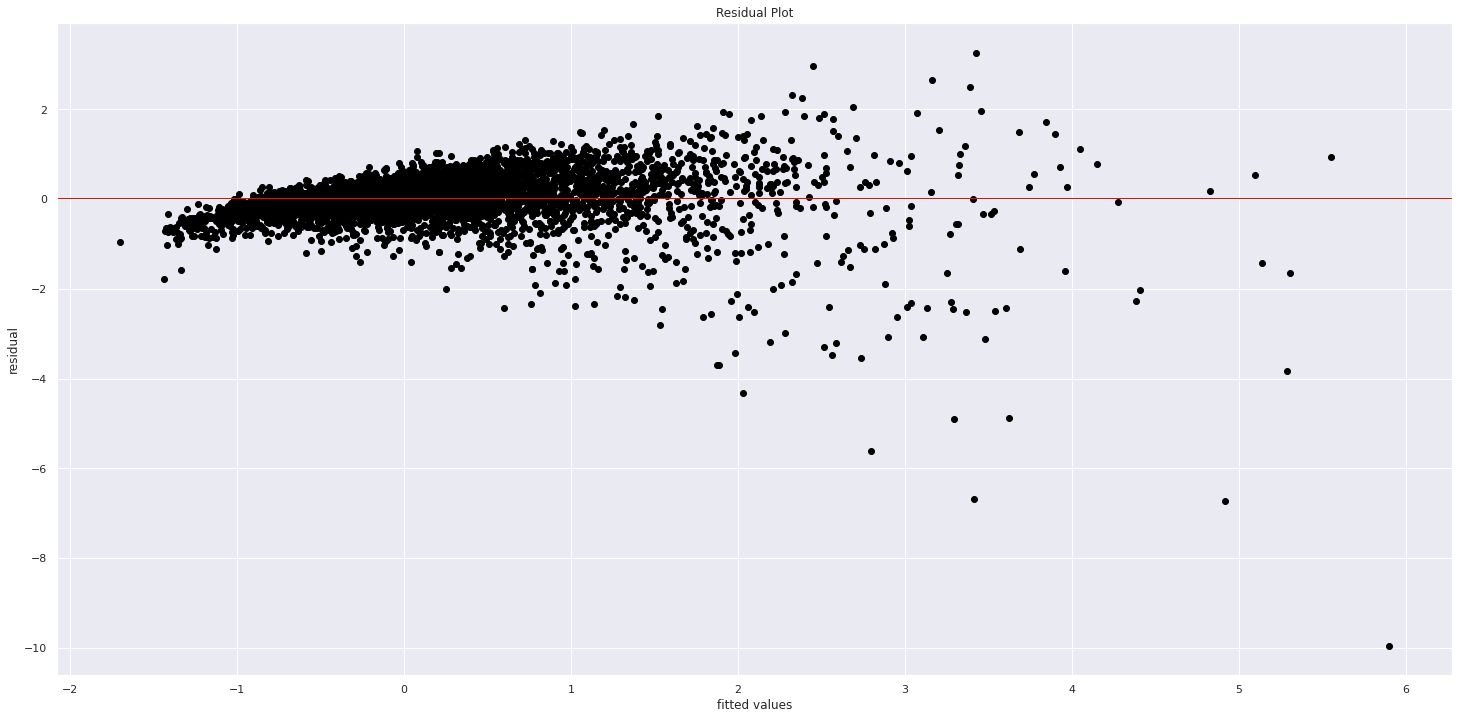

In [ ]:
plt.scatter(price_predict, residuals, color='black')
plt.ylabel('residual')
plt.xlabel('fitted values')
plt.title('Residual Plot')
plt.axhline(y= residuals.mean(), color='red', linewidth=1)
plt.show()

In [ ]:
import scipy as sp

test_result, p_value = sp.stats.bartlett(price_predict, residuals)

# To interpret the results we must also compute a critical value of the chi squared distribution
degree_of_freedom = len(price_predict)-1
probability = 1 - p_value

critical_value = sp.stats.chi2.ppf(probability, degree_of_freedom)
print(critical_value)

# If the test_result is greater than the critical value, then we reject our null
# hypothesis. This would mean that there are patterns to the variance of the data

# Otherwise, we can identify no patterns, and we accept the null hypothesis that 
# the variance is homogeneous across our data

if (test_result > critical_value):
  print('the variances are unequal, and the model should be reassessed')
else:
  print('the variances are homogeneous!')

inf
the variances are homogeneous!


In [ ]:
critical_value

inf

##6.3 Linear Regression Model

In [ ]:
# split training data and test data 
X_train, X_test, price_train, price_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from matplotlib.ticker import LinearLocator
#Training the Lagorithm 

#To train the algorithm we execuite the same code as before using thr fit() to the Linear Regression


from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, price_train)

LinearRegression()

In [ ]:
# In case of multivariable linear regression, the regression model has to 
# find the most optimal coefficients for all the attributes. 
# To see what coefficients our regression model has chosen, execute the following
# 
coeff_df = pd.DataFrame(regressor.coef_, 
                        df1.drop(columns=['grade', 'price','id']).columns, columns=['Coefficient'])
coeff_df
# From the output, this means that for a unit increase in "bathrooms", 
# there is a decrease of 50772 in house price. 
# Similarly, a unit increase in floors there is an increase in 22060 in house  price=

,Coefficient
bedrooms,-0.139860
bathrooms,0.117875
sqft_living,0.000001
sqft_lot,0.003833
floors,0.068289
waterfront,1.809738
view,0.188181
condition,0.091439
sqft_above,0.000767
sqft_basement,0.000582


In [ ]:
# Making Predictions
# ---
# To make pre-dictions on the test data, execute the following
# ---
# 
y_pred = regressor.predict(X_test)

# To compare the actual output values for X_test with the predicted values
# 
df = pd.DataFrame({'Actual': price_test, 'Predicted': y_pred})
df


,Actual,Predicted
0,-0.473611,-0.009466
1,3.497911,3.024770
2,0.347005,0.192942
3,0.561833,0.037452
4,1.021514,1.725573
5,0.108342,-0.058475
6,-0.340505,-0.050739
7,-0.354106,-0.067527
8,-0.077387,0.160958
9,0.123820,2.384900


In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(price_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(price_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(price_test, y_pred)))

# We can see that the value of root mean squared error is 201768.68,
#which is significantly higher than 10% of the fouse price mean
#WHpich mewans our algorithm isn't accuarte at all 

Mean Absolute Error: 0.4067046680937175
Mean Squared Error: 0.3900928244618549
Root Mean Squared Error: 0.624574114466694


In [ ]:
df1.price.mean()

0.27915851661761015

##6.4 Quantile Regression


In [ ]:
df2 = pd.read_csv('./house.csv')

In [ ]:
dfq = df2[['bedrooms', 'price']]

In [ ]:
dfq.head()

,bedrooms,price
0,3,221900.0
1,3,538000.0
2,2,180000.0
3,4,604000.0
4,3,510000.0


In [ ]:
dfq.describe()

,bedrooms,price
count,21613.000000,2.161300e+04
mean,3.370842,5.401822e+05
std,0.930062,3.673622e+05
min,0.000000,7.500000e+04
25%,3.000000,3.219500e+05
50%,3.000000,4.500000e+05
75%,4.000000,6.450000e+05
max,33.000000,7.700000e+06


In [ ]:
train_df, test_df = train_test_split(dfq, test_size=0.10, shuffle=False)


In [ ]:

X_train, y_train = train_df[['bedrooms']], train_df[['price']]
X_test, y_test = test_df[['bedrooms']], test_df[['price']]

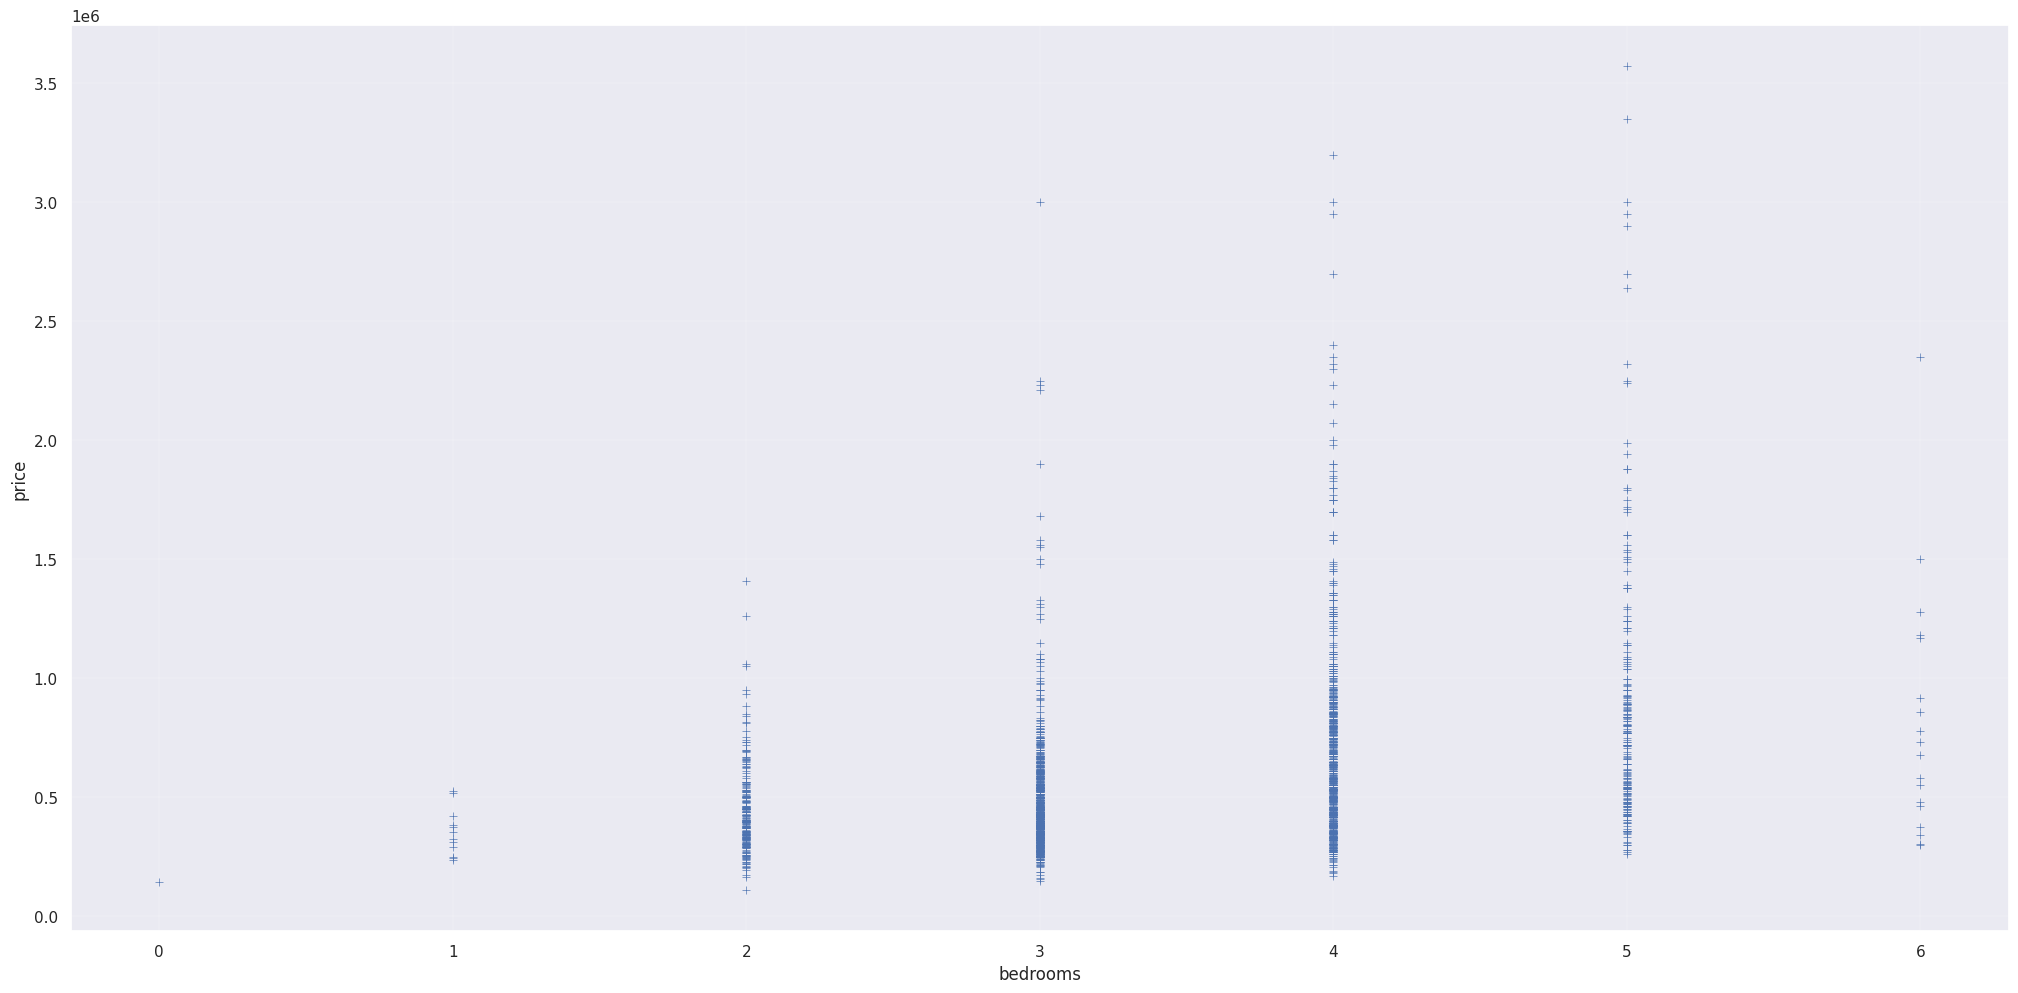

In [ ]:
plt.rcParams.update({'font.size': 10, 'figure.dpi':100})
sns.scatterplot(data=test_df, x="bedrooms", y="price", marker='+')
plt.grid(linestyle='-', linewidth=0.2)

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
classifiers = {}
for tau in [0.1, 0.5, 0.9]:
    clf = LGBMRegressor(objective='quantile', alpha=tau)
    clf.fit(X_train, y_train)
    preds = pd.DataFrame(clf.predict(X_test), columns = [str(tau)])
    classifiers[str(tau)] = {'clf': clf, 'predictions': preds}

In [ ]:
data = pd.DataFrame({'bedrooms': X_test.reset_index()['bedrooms'],
              '0.1': classifiers['0.1']['predictions']['0.1'],
              '0.5': classifiers['0.5']['predictions']['0.5'],
              '0.9': classifiers['0.9']['predictions']['0.9'],
              'bedrooms': y_test.reset_index()['price']})

In [ ]:
data.sample(3)

,bedrooms,0.1,0.5,0.9
386,1260000.0,316397.995123,604995.856422,1.379987e+06
569,739000.0,230000.265614,410001.035895,7.478032e+05
1198,424950.0,199081.067362,369002.124912,6.051072e+05


In [ ]:
melted_data = pd.melt(data, id_vars=['bedrooms'])

In [ ]:
melted_data.head()

,bedrooms,variable,value
0,269950.0,0.1,230000.265614
1,142000.0,0.1,147702.479082
2,300000.0,0.1,230000.265614
3,780000.0,0.1,199081.067362
4,545000.0,0.1,230000.265614


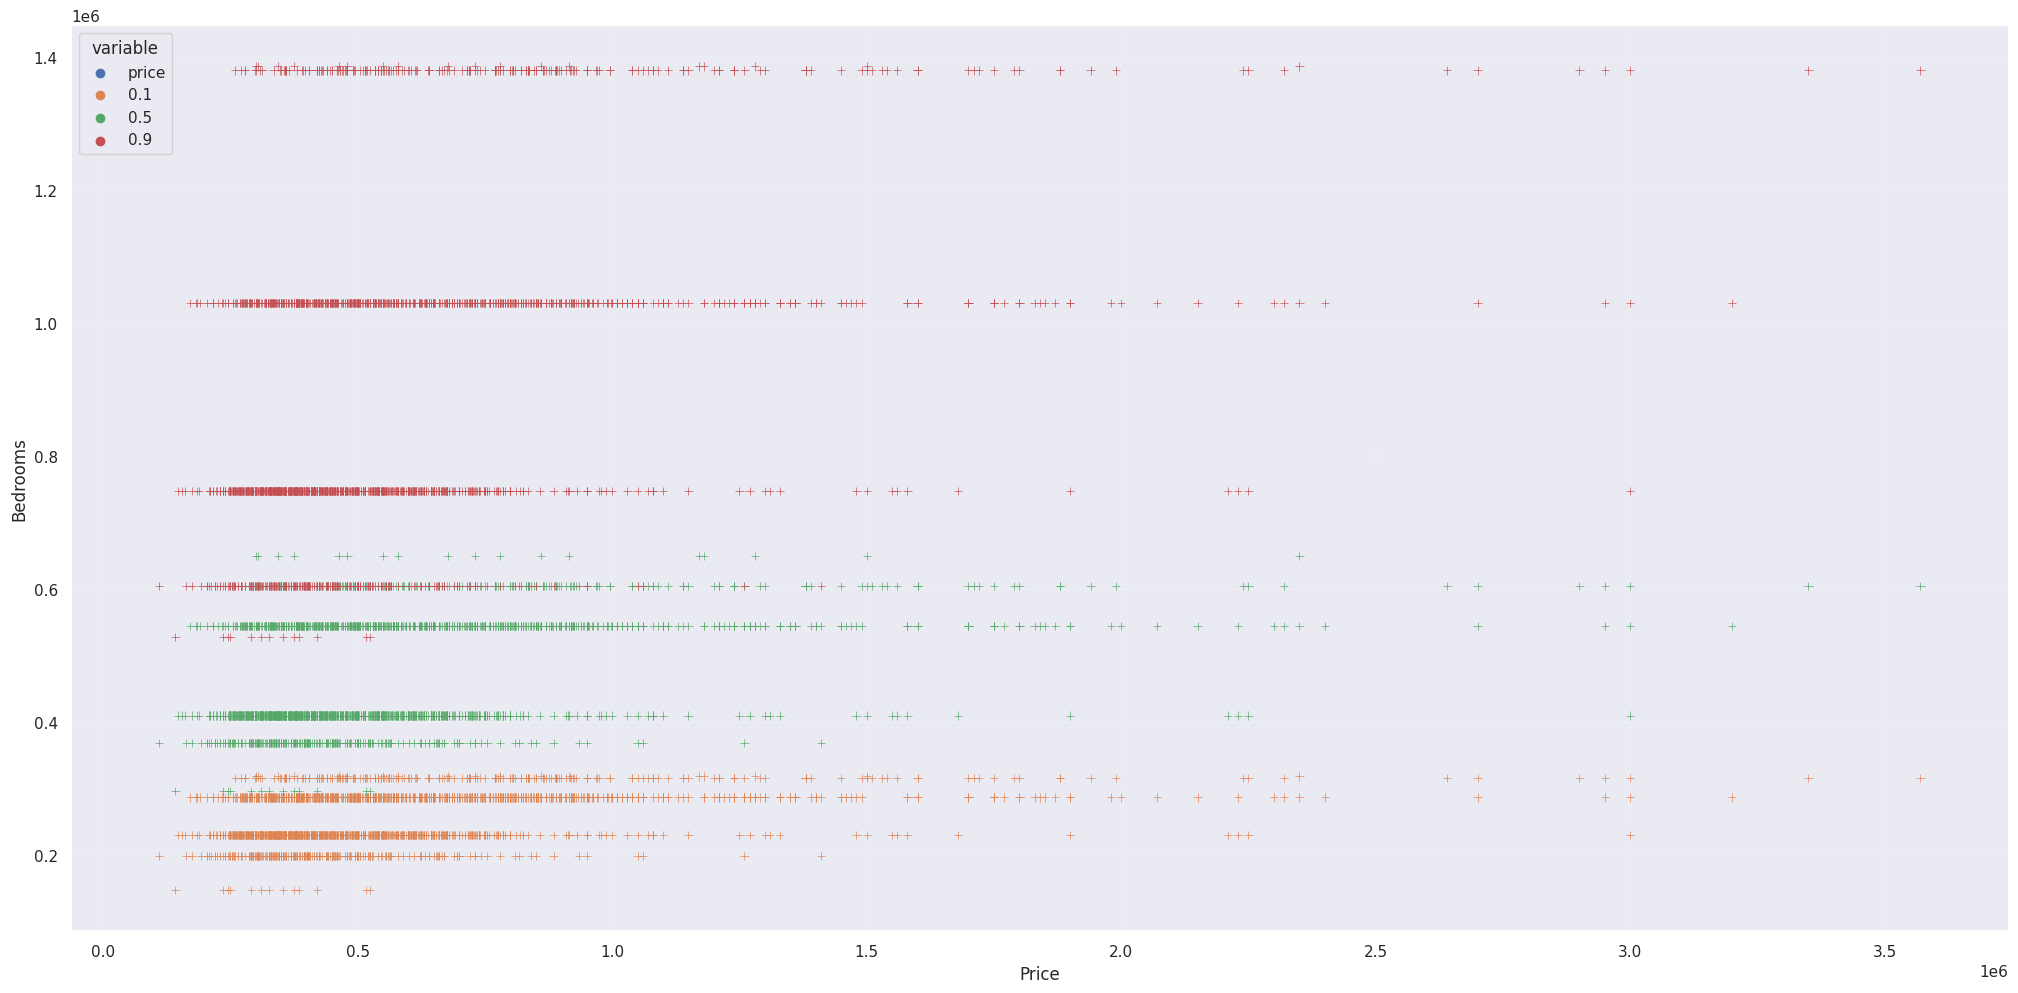

In [ ]:
plt.rcParams.update({'font.size': 10, 'figure.dpi':100})
sns.scatterplot(data=melted_data, 
                x="bedrooms",
                y='value',
                hue='variable',
                hue_order=['price', '0.1', '0.5', '0.9'],
                marker='+')
plt.grid(linestyle='-', linewidth=0.2)
ylabel = plt.ylabel("Bedrooms")
xlabel = plt.xlabel("Price")

In [ ]:
df2.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

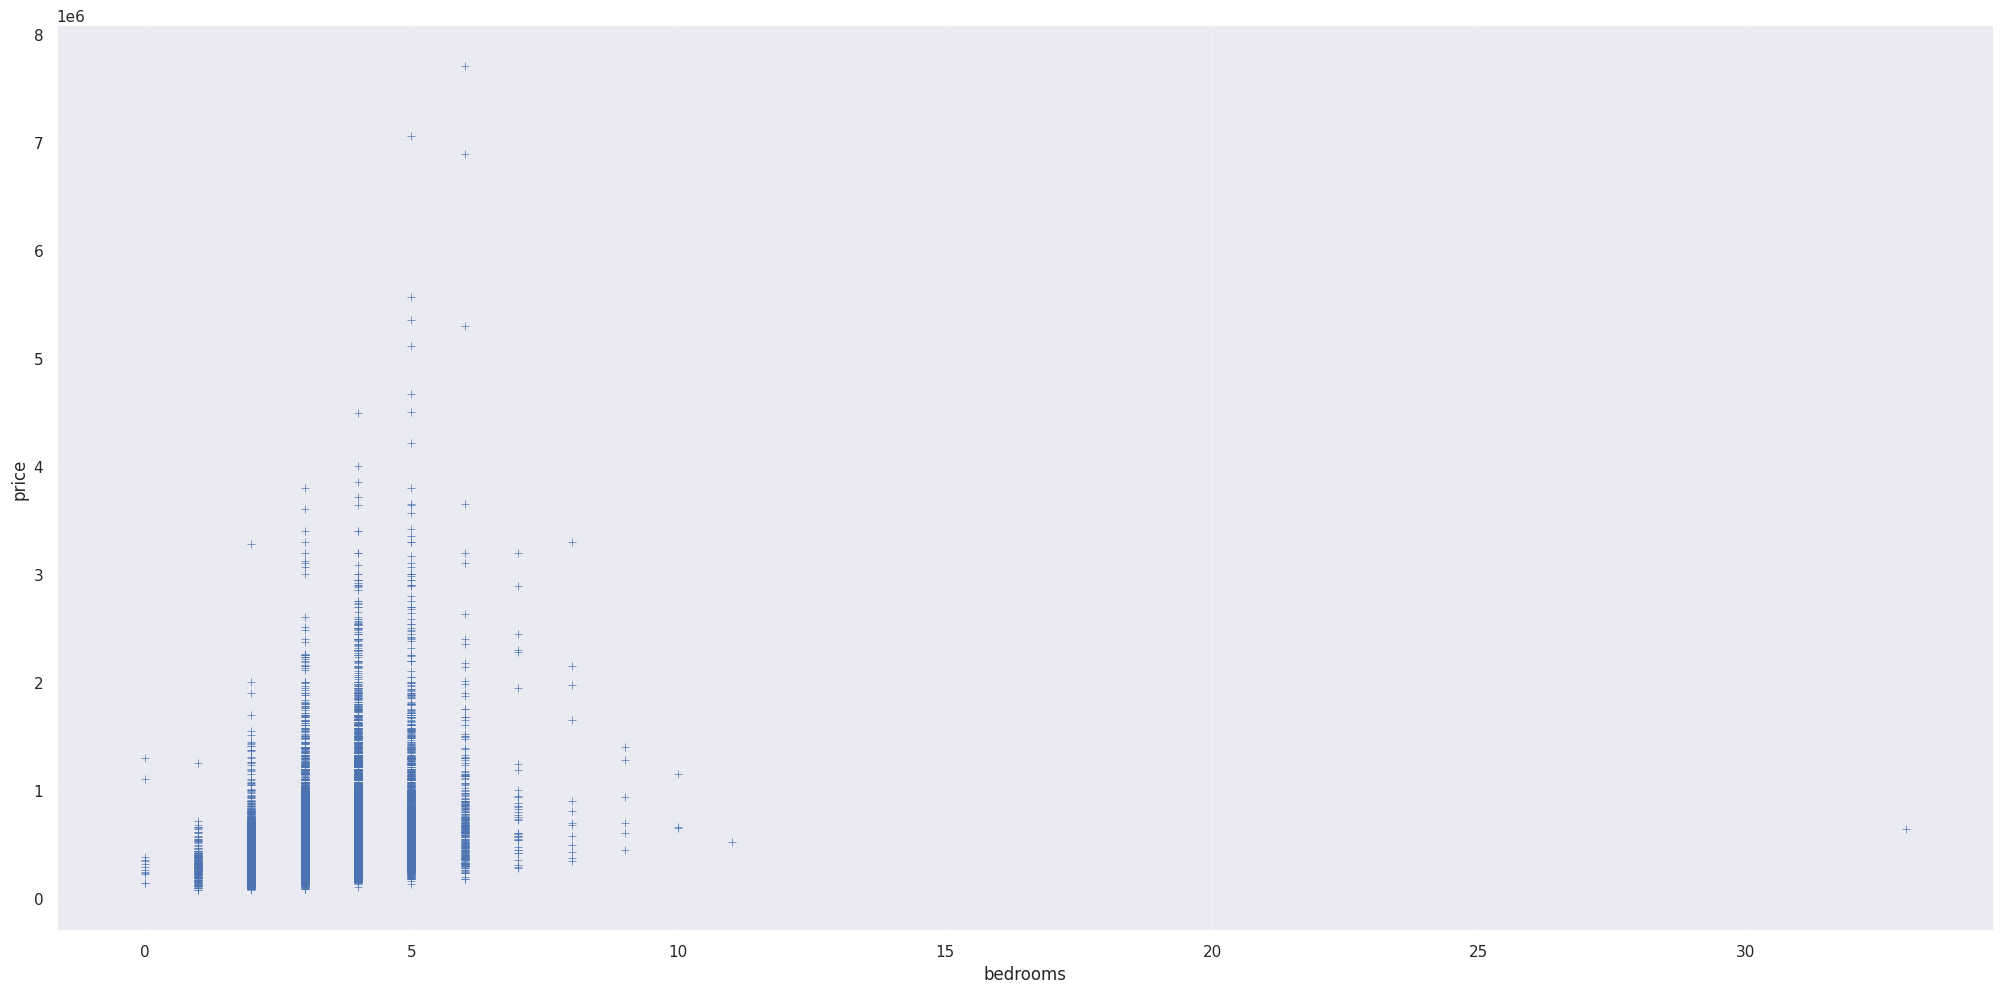

In [ ]:

sns.scatterplot(data=df2, x="bedrooms", y="price", marker='+')
plt.grid(linestyle='-', linewidth=0.2)

In [ ]:
## Creating a linear regression model regression on the above dataset
#
from sklearn.linear_model import LinearRegression
x = df2['bedrooms'].values.reshape(-1,1)
y = df2['price'].values 
model1 = LinearRegression(fit_intercept = True, normalize = False)
model1.fit(x, y )

y_pred1 = model1.predict(x)

print("Mean squared error: {0:.2f}"
      .format(np.mean((y_pred1 - y) ** 2)))
print('Variance score: {0:.2f}'.format(model1.score(x, y)))

print(f'Price Mean: {df2.price.mean()}')

# With a low variance score of 0.10, it means that our linear regression 
# did not do a good job. 

Mean squared error: 122118841966.45
Variance score: 0.10
Price Mean: 540182.1587933188


Text(0.5, 1.0, 'Linear regression')

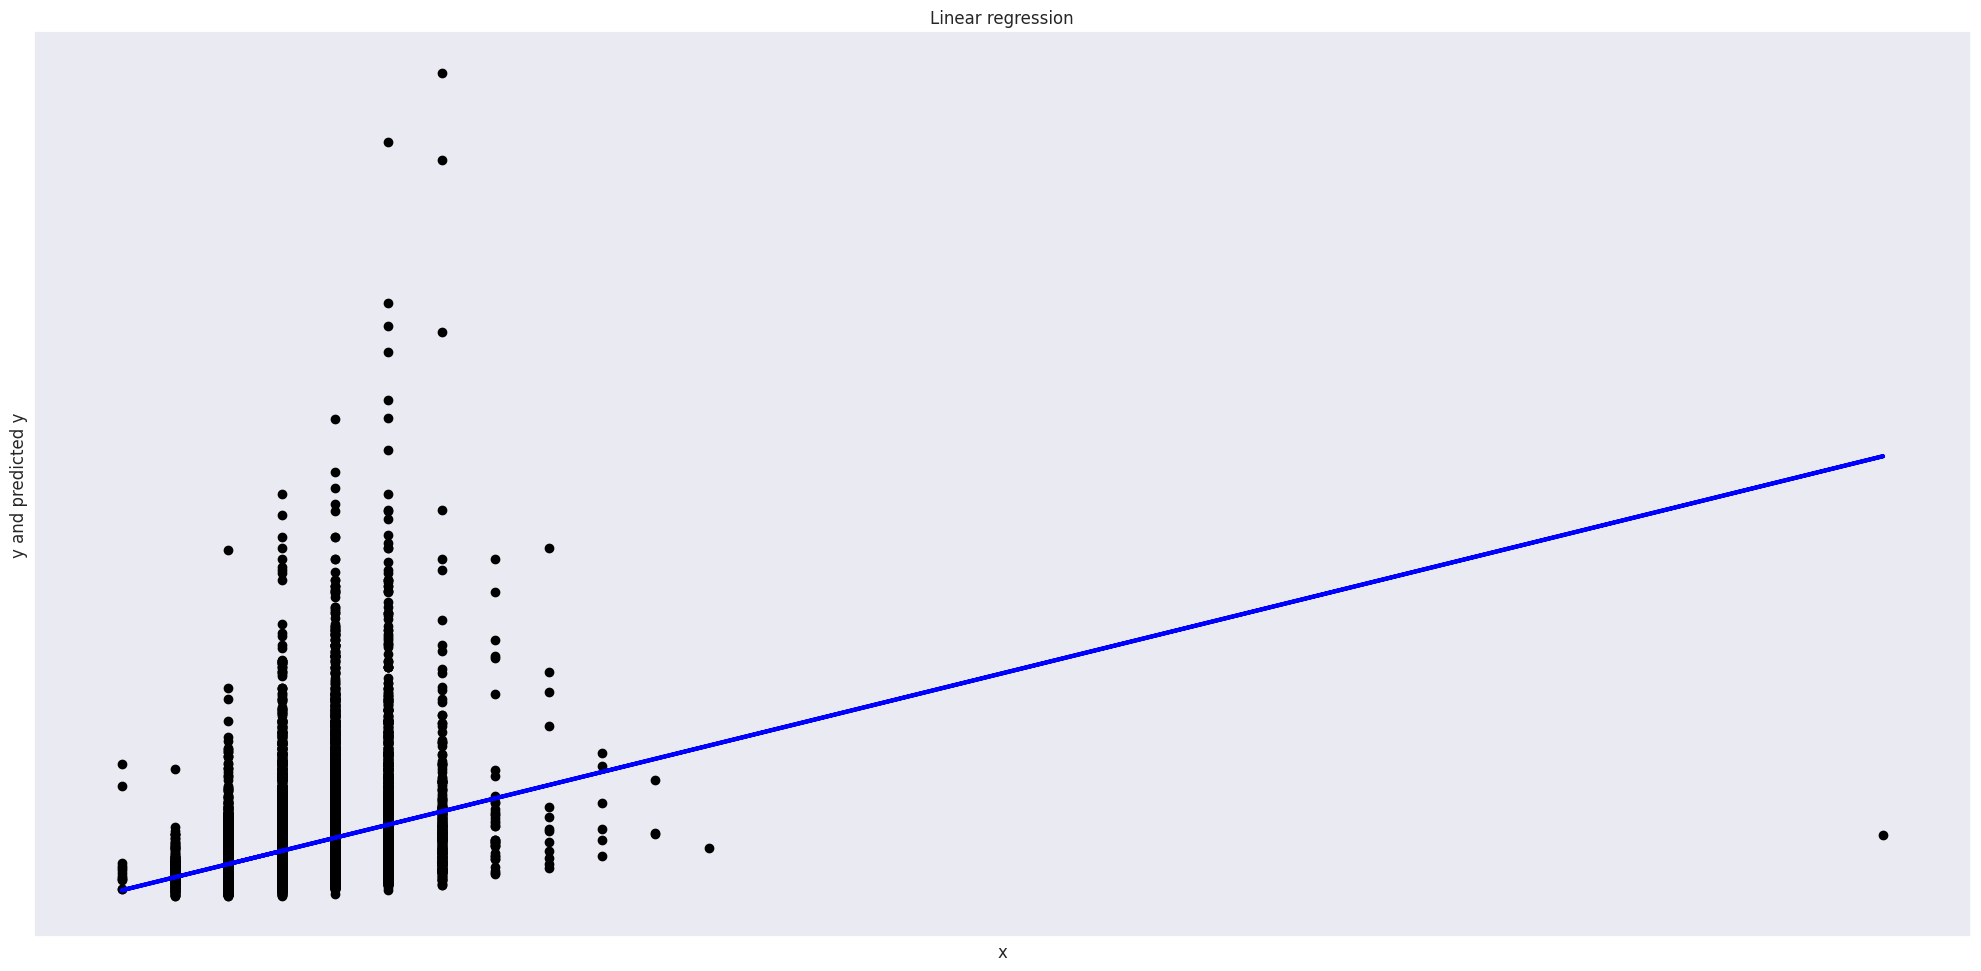

In [ ]:
plt.figure(2)
plt.scatter(x, y,  color='black')
plt.plot(x, y_pred1, color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())
plt.xlabel("x")
plt.ylabel("y and predicted y")
plt.title("Linear regression")

Massive undefitting with the linear regression model. Lets try out Quantile

In [ ]:
# We will use the python package statsmodels for Quantile Regression
#
import statsmodels.formula.api as smf

# Finding the regression coefficients for the conditioned median, 0.5 quantile
#
mod = smf.quantreg('y ~ x', df2)
res = mod.fit(q=.5)

# Then print out the summary of our model
#
print(res.summary())



                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:              0.04634
Model:                       QuantReg   Bandwidth:                   4.011e+04
Method:                 Least Squares   Sparsity:                    5.565e+05
Date:                Sat, 11 Jun 2022   No. Observations:                21613
Time:                        10:32:19   Df Residuals:                    21611
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     1.8e+05   7116.256     25.294      0.000    1.66e+05    1.94e+05
x             8.5e+04   2035.082     41.767      0.000     8.1e+04     8.9e+04


In [ ]:
## Similarly we can do the models for other quantiles
# 
quantiles = np.arange(0.1,1,0.1) 
models = []
params = []

# We build models for each quantile in our list quantiles inside a for loop
# As we build these models we also store the model parameters in a list called params. 
for qt in quantiles: 
	res = mod.fit(q = qt )
	models.append(res)
	params.append([qt, res.params['Intercept'], res.params['x']] + res.conf_int().loc['x'].tolist())

# Lastly we make a dataframe of the same name, so we we can view our different models.
params = pd.DataFrame(data = params, columns = ['qt', 'intercept', 'x_coef', 'cf_lower_bound', 'cf_upper_bound'])
print(params)

    qt      intercept         x_coef  cf_lower_bound  cf_upper_bound
0  0.1  119799.999998   40050.000001    37229.863749    42870.136252
1  0.2  134999.999998   50000.000001    47090.040224    52909.959778
2  0.3  149999.999997   61000.000001    57588.467088    64411.532913
3  0.4  165000.000001   72500.000000    68715.999777    76284.000222
4  0.5  179999.999994   85000.000002    81011.089434    88988.910569
5  0.6  188333.333332  101666.666668    96935.251255   106398.082081
6  0.7  189574.999998  122712.500001   117862.339626   127562.660376
7  0.8  191000.000004  151999.999998   145540.451783   158459.548213
8  0.9  150000.000000  215000.000000   203126.078983   226873.921016


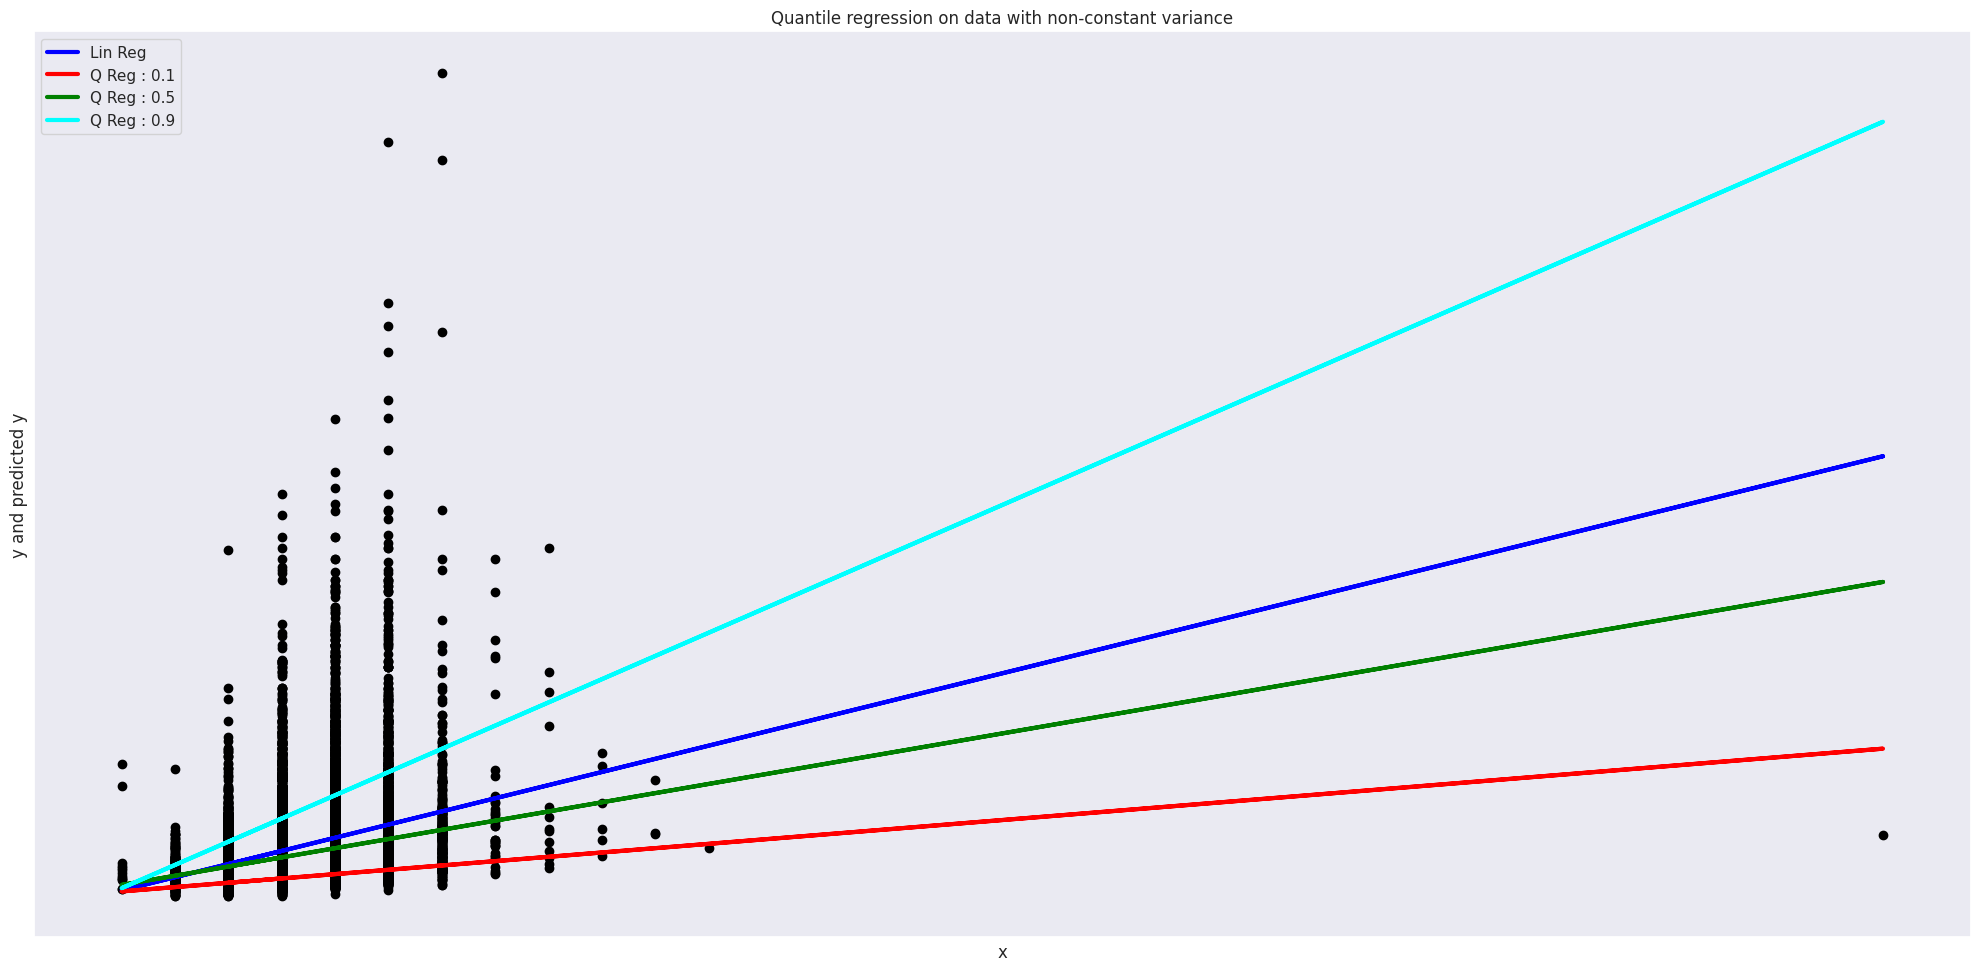

In [ ]:
## Let us now plot 0.1th, 0.5th and 0.9th quantile models against our original data.
# 
plt.figure(5)
plt.scatter(x, y,  color='black')
plt.plot(x, y_pred1, color='blue',
         linewidth=3, label='Lin Reg')

y_pred3 = models[0].params['Intercept'] + models[0].params['x'] * x
plt.plot(x, y_pred3, color='red',
         linewidth=3, label='Q Reg : 0.1')

y_pred4 = models[4].params['Intercept'] + models[4].params['x'] * x
plt.plot(x, y_pred4, color='green',
         linewidth=3, label='Q Reg : 0.5')


y_pred5 = models[8].params['Intercept'] + models[8].params['x'] * x
plt.plot(x, y_pred5, color='cyan',
         linewidth=3, label='Q Reg : 0.9')

plt.xticks(())
plt.yticks(())
plt.xlabel("x")
plt.ylabel("y and predicted y")
plt.title("Quantile regression on data with non-constant variance")
plt.legend()

## 6.5 Ridge Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
df3 = df2.copy()

In [ ]:
df3.sample(2)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8920,2048000330,214000.0,3,2.5,1600,2231,2.0,0,0,3,7,1600,0,2003,0,98001,47.3314,-122.290,1600,2962
3692,7468900245,188200.0,3,1.0,1260,7265,1.0,0,0,4,7,1260,0,1954,0,98002,47.2979,-122.224,940,7200


In [ ]:
#Separate independent variables and dependent variables

X = df3.drop(columns=['price', 'id'])
y = df3['price']

In [ ]:
# Creating our baseline regression model
# This is a model that has no regularization to it

regression = LinearRegression()
regression.fit(X, y)
first_model =  (mean_squared_error(y_true=y,y_pred=regression.predict(X)))
print(first_model)

40518022074.275925


In [ ]:
# In order to create our ridge model we need to first determine the most appropriate value for the l2 regularization. 
# L2 is the name of the hyperparameter that is used in ridge regression. 
# Determining the value of a hyperparameter requires the use of a grid. 
# In the code below, we first create our ridge model and indicate normalization in order to get better estimates. 
# Next we setup the grid that we will use. 
# The search object has several arguments within it. Alpha is hyperparameter we are trying to set. 
# The log space is the range of values we want to test. 
# We want the log of -5 to 2, but we only get 8 values from within that range evenly spread out. 
# Are metric is the mean squared error. Refit set true means to adjust the parameters while modeling 
# and cv is the number of folds to develop for the cross-validation
ridge = Ridge(normalize=True)
search = GridSearchCV(estimator=ridge,param_grid={'alpha':np.logspace(-5,2,8)},
                      scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)

In [ ]:
# We now use the .fit function to run the model and then use the .best_params_ and
#  .best_scores_ function to determine the models strength. 
# 
search.fit(X,y)
search.best_params_
{'alpha': 0.01}
abs(search.best_score_) 

# The best_params_ tells us what to set alpha too which in this case is 0.01. 
# The best_score_ tells us what the best possible mean squared error is. 
# In this case, the value of 0.38 is worse than what the baseline model was.

41016657649.82225

In [ ]:
# We can confirm this by fitting our model with the ridge information and finding the mean squared error below
#
ridge = Ridge(normalize=True,alpha=0.01)
ridge.fit(X,y)
second_model = (mean_squared_error(y_true=y,y_pred=ridge.predict(X)))
print(second_model)


40524344765.439


In [ ]:
# The 0.35 is lower than the 0.38. This is because the last results are not cross-validated. 
# In addition, these results indicate that there is little difference between the ridge and baseline models. 
# This is confirmed with the coefficients of each model found below.
# 
coef_dict_baseline = {}
for coef, feat in zip(regression.coef_,df3.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

# The coefficient values are about the same. This means that the penalization made little difference with this dataset.

{'bathrooms': 0.12840424994483035,
 'bedrooms': 110.51388750604916,
 'condition': 70.82712642204363,
 'floors': 52934.07499962661,
 'grade': 39.68676095797481,
 'id': -35797.78526878027,
 'lat': 21.67584906828925,
 'long': -0.3824610304036469,
 'price': 41166.76100968799,
 'sqft_above': -2622.410499457613,
 'sqft_basement': 19.824180497913297,
 'sqft_living': 6695.157538716981,
 'sqft_lot': 583016.9475137593,
 'view': 95985.79230523002,
 'waterfront': 26412.954334727685,
 'yr_built': -582.5716677591586,
 'yr_renovated': 602825.2080907875,
 'zipcode': -214960.62365184783}

##6.6 Lasso Regression


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler


In [ ]:
df4 = df3.copy()

In [ ]:
X = df3.drop(columns=['price', 'id'])
y = df3['price']

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Creating lasso object
# 
lasso = linear_model.Lasso() 

# Fitting the models
# 
lasso.fit(X, y) 

# Print scores, MSE, and coefficients
# 
print("lasso score:", lasso.score(X, y)) 
print("lasso MSE:", mean_squared_error(y, lasso.predict(X))) 
print("lasso coef:", lasso.coef_) 

lasso score: 0.6997525536733683
lasso MSE: 40518022116.35509
lasso coef: [-33292.21075087  31697.82535674 259457.31589161   5315.2138083
   3614.96948484  50439.07198689  40563.44510569  17186.55108076
 112827.34401399 -83763.68277541 -58548.42851749 -77025.47282042
   7962.04001793 -31167.26388666  83526.36572597 -30269.33526327
  14850.06168935 -10439.75419149]


In [ ]:
# Splitting the data into training and test sets, building Lasso, 
# and choosing the regularization parameter with the help of GridSearch. 
# For that, we have to define the set of parameters for GridSearch. 
# In this case, a model with the highest R-squared score will give us the best parameters.
# 

# Making necessary imports, split data into training and test sets, and choose a set of parameters 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}

linear = linear_model.LinearRegression()
lasso = linear_model.Lasso() 
gridlasso = GridSearchCV(lasso, parameters, scoring ='r2') 

# Fitting models and print the best parameters, R-squared scores, MSE, and coefficients
gridlasso.fit(X_train, y_train) 
linear.fit(X_train, y_train) 
print("lasso best parameters:", gridlasso.best_params_) 
print("lasso score:", gridlasso.score(X_test, y_test))
print("linear score:", linear.score(X_test, y_test)) 
print("lasso MSE:", mean_squared_error(y_test, gridlasso.predict(X_test)))
print("linear MSE:", mean_squared_error(y_test, linear.predict(X_test))) 
print("lasso best estimator coef:", gridlasso.best_estimator_.coef_)
print("linear coef:", linear.coef_)

lasso best parameters: {'alpha': 20.0}
lasso score: 0.709737266449461
linear score: 0.7097371661736289
lasso MSE: 41207692537.709816
linear MSE: 41207706773.55611
lasso best estimator coef: [-34399.26702209  27826.88444502 213844.83375544   5845.12153666
   6144.15539399  47879.09903978  39684.71760347  18935.3878054
 113135.72205796 -43001.50020408 -37181.52068471 -76980.27224601
   7040.26792609 -31409.30061759  83481.79136105 -30551.83911637
  16660.95954141  -9750.52732037]
linear coef: [-34424.53431839  27957.40583739  81485.85675279   5907.38589433
   6148.95398688  47893.17781724  39683.13024123  18956.70853482
 113082.92867187  76207.216416    26511.74127583 -77017.70465605
   7054.14554193 -31459.79907513  83510.25030616 -30601.42184926
  16779.87752303  -9804.1759509 ]


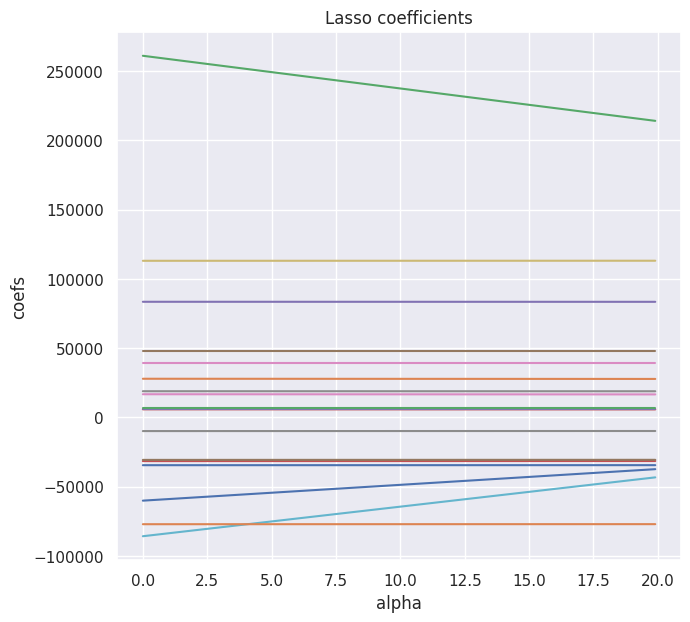

In [ ]:
# Importing library for visualization
#
import matplotlib.pyplot as plt
coefsLasso = [] 

# Building Lasso for 200 values of alpha and write the coefficients into array
# 
alphasLasso = np.arange (0, 20, 0.1) 
for i in range(200):
    lasso = linear_model.Lasso(alpha=alphasLasso[i])
    lasso.fit(X_train, y_train)
    coefsLasso.append(lasso.coef_) 

# Building Lasso coefficient plots
# 
plt.figure(figsize = (16,7))

plt.subplot(121)
plt.plot(alphasLasso, coefsLasso)
plt.title('Lasso coefficients')
plt.xlabel('alpha')
plt.ylabel('coefs')

plt.show()

# As we can see, Lasso influences less on the large coefficients, but the small ones Lasso reduces to zeroes. 
# Therefore Lasso can also be used to determine which features are important 
# to us and keeps the features that may influence the target variable

##6.7 Elastic Net Regression


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
df5 = df4.copy()

In [ ]:
X = df5.drop(columns = ['id', 'price'])
y = df5.price

In [ ]:
# Creating our linear regression model for the purpose of comparison
# 
regression=LinearRegression()
regression.fit(X,y)
first_model=(mean_squared_error(y_true=y,y_pred=regression.predict(X)))
print(first_model) 

# This mean standard error score of 40518022074.275925is our benchmark for determining 
# if the elastic net model will be better or worst. 

40518022074.275925


In [ ]:
# Below are the coefficients of this first model. We use a for loop to go through 
# the model and the zip function to combine the two columns.
# 
coef_dict_baseline = {}
for coef, feat in zip(regression.coef_,X.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

{'bathrooms': 41166.76100968799,
 'bedrooms': -35797.78526878027,
 'condition': 26412.954334727685,
 'floors': 6695.157538716981,
 'grade': 95985.79230523002,
 'lat': 602825.2080907875,
 'long': -214960.62365184783,
 'sqft_above': 70.82712642204363,
 'sqft_basement': 39.68676095797481,
 'sqft_living': 110.51388750604916,
 'sqft_living15': 21.67584906828925,
 'sqft_lot': 0.12840424994483035,
 'sqft_lot15': -0.3824610304036469,
 'view': 52934.07499962661,
 'waterfront': 583016.9475137593,
 'yr_built': -2622.410499457613,
 'yr_renovated': 19.824180497913297,
 'zipcode': -582.5716677591586}

In [ ]:
# Elastic Net Model
# Elastic net, just like ridge and lasso regression, requires normalize data. 
# This argument  is set inside the ElasticNet function. 
# The second thing we need to do is create our grid.
# 
elastic=ElasticNet(normalize=True)
search=GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)

In [ ]:
# We will now fit our model and display the best parameters and the best results we can get with that setup.
# 
search.fit(X,y)
search.best_params_

{'alpha': 1e-05, 'l1_ratio': 0.8}

In [ ]:
# The best hyperparameters was an alpha set to 0.001 and a l1_ratio of 0.8. 
# With these settings we got an MSE of 1.08. This is above our baseline model of MSE 1.05  for the baseline model. 
# Which means that elastic net is doing worse than linear regression. 
# For clarity, we will set our hyperparameters to the recommended values and run on the data.
# 
elastic=ElasticNet(normalize=True,alpha=0.001,l1_ratio=0.75)
elastic.fit(X,y)
second_model=(mean_squared_error(y_true=y,y_pred=elastic.predict(X)))
print(second_model)

79376555016.66553


In [ ]:
# Below are the coefficients
# 
coef_dict_baseline = {}
for coef, feat in zip(elastic.coef_,X.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

# The coefficients are mostly the same. 
# Notice that occupation was completely removed from the model in the elastic net version. 
# This means that this values was no good to the algorithm. Traditional regression cannot do this.

{'bathrooms': 23091.814427233778,
 'bedrooms': 9155.504009716382,
 'condition': 5771.699965611121,
 'floors': 14344.85611049671,
 'grade': 22210.389114051002,
 'lat': 117967.60514689352,
 'long': -19353.74153969671,
 'sqft_above': 26.88253093636235,
 'sqft_basement': 29.913482419991606,
 'sqft_living': 28.799709870733352,
 'sqft_living15': 31.194117802574013,
 'sqft_lot': 0.058884694865293664,
 'sqft_lot15': 0.06329940772824336,
 'view': 21942.804290075466,
 'waterfront': 143890.34582180186,
 'yr_built': -116.48434589869713,
 'yr_renovated': 14.761443494182139,
 'zipcode': -5.75846185452919}